# ДИПЛОМНЫЙ ПРОЕКТ "Модель прогнозирования стоимости жилья для агентства недвижимости"

Цель - разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.  

Задачи:

* очистить данные от выбросов, пропусков, дублей;
* провести расведовательный анализ, выделить наиболее значимые факторы, влияющие на стоимость недвижимости;
* построить несколько моделей и выбрать демонстрирующую лучший результат;
* разработать небольшой веб-сервис, принимающий данные о выставленной на продажу недвижимости и возвращающий прогноз стоимости;

## 1. ИССЛЕДОВАНИЕ ДАННЫХ

### 1.1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

from itertools import chain

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler

%matplotlib inline
matplotlib.style.use('ggplot')

### 1.2. Загрузка данных

In [2]:
df = pd.read_csv('data/data.csv')

### 1.3. Знакомство с данными

**Описание признаков:**

➔ 'status' — статус продажи;

➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;

➔ 'propertyType' — тип объекта недвижимости;

➔ 'street' — адрес объекта;

➔ 'baths' — количество ванных комнат;

➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);

➔ 'fireplace' — наличие камина;

➔ 'city' — город;

➔ 'schools' — сведения о школах в районе;

➔ 'sqft' — площадь в футах;

➔ 'zipcode' — почтовый индекс;

➔ 'beds' — количество спален;

➔ 'state' — штат;

➔ 'stories' — количество этажей;

➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);

➔ **'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).**

In [3]:
df.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [5]:
missing_data = df.isnull().sum()

# Выводим столбцы, которые содержат пропуски и их количество (в процентах)
for column_name, missing_count in missing_data.items():
    if missing_count > 0:
        percentage = (missing_count / len(df)) * 100
        print(f'{column_name}: {missing_count} пропусков ({percentage:.2f}% от общего числа данных в столбце)')

status: 39918 пропусков (10.58% от общего числа данных в столбце)
private pool: 373004 пропусков (98.89% от общего числа данных в столбце)
propertyType: 34733 пропусков (9.21% от общего числа данных в столбце)
street: 2 пропусков (0.00% от общего числа данных в столбце)
baths: 106338 пропусков (28.19% от общего числа данных в столбце)
fireplace: 274071 пропусков (72.66% от общего числа данных в столбце)
city: 34 пропусков (0.01% от общего числа данных в столбце)
sqft: 40577 пропусков (10.76% от общего числа данных в столбце)
beds: 91282 пропусков (24.20% от общего числа данных в столбце)
stories: 150716 пропусков (39.96% от общего числа данных в столбце)
mls-id: 352243 пропусков (93.39% от общего числа данных в столбце)
PrivatePool: 336874 пропусков (89.31% от общего числа данных в столбце)
MlsId: 66880 пропусков (17.73% от общего числа данных в столбце)
target: 2481 пропусков (0.66% от общего числа данных в столбце)


В датасете имеем 377185 разных объектов недвижимости описанных восемнадцатью признаками.
Все признаки представлены типом object, в том числе целевой, имеются пропуски в 14 признаках.

## 2. ОЧИСТКА ДАННЫХ

### 2.1. Призаки MlsId и mls-id и удаление дублей

Поскольку MlsId и mls-id - это код в централизованной системе учёта предложений объектов недвижимости, то на цену объекта он ни как не влияет, и эти признаки можно удалить.

In [6]:
# Удаляем признаки MlsId и mls-id
df.drop(['mls-id','MlsId'],axis=1, inplace=True)

In [7]:
# Удаляем строки не имеющие значения целевого признака target
df = df.dropna(subset=['target'])

In [8]:
# Посмотрим количество дубликатов
print("Количество дубликатов: ", df.duplicated().sum())

Количество дубликатов:  140


In [9]:
#Удалим дубликаты
df = df.drop_duplicates(ignore_index=True)

In [10]:
# Посмотрим количество дубликатов без учета признака 'target'
mask = df.drop('target',axis=1).duplicated()
print("Количество дубликатов без учета признака 'target': ", mask.sum())
# Есть дубликаты, видимо менялась цена на объекты недвижимости, их немного просто удалим их

Количество дубликатов без учета признака 'target':  38


In [11]:
#Удалим дубликаты
df = df[~mask]

In [12]:
# Посмотрим количество дубликатов без учета признака 'status'
mask = df.drop('status',axis=1).duplicated()
print("Количество дубликатов без учета признака 'status': ", mask.sum())
# Есть дубликаты, видимо менялся статус на объекты недвижимости, их немного просто удалим их

Количество дубликатов без учета признака 'status':  4


In [13]:
df = df[~mask]

In [14]:
# Вот что имеем после всех выполненных операций
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374522 entries, 0 to 374563
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        335267 non-null  object
 1   private pool  4151 non-null    object
 2   propertyType  339982 non-null  object
 3   street        374520 non-null  object
 4   baths         269249 non-null  object
 5   homeFacts     374522 non-null  object
 6   fireplace     102516 non-null  object
 7   city          374491 non-null  object
 8   schools       374522 non-null  object
 9   sqft          334452 non-null  object
 10  zipcode       374522 non-null  object
 11  beds          283672 non-null  object
 12  state         374522 non-null  object
 13  stories       224895 non-null  object
 14  PrivatePool   40120 non-null   object
 15  target        374522 non-null  object
dtypes: object(16)
memory usage: 48.6+ MB


### 2.2. Призаки 'private pool' и 'PrivatePool'

Поскольку 'private pool' и 'PrivatePool' содержат дублирующую информацию то объеденим их так же отметим поскольку у нас всего 3 значения то вероятнее всего пропуск свидетельствует о отсутствии бассейна закодируем его булевыми переменными

In [15]:
# Объединяем столбцы
df['pool'] = df['private pool'].combine_first(df['PrivatePool'])
# Удаляем столбец PrivatePool
df = df.drop(['PrivatePool', 'private pool'], axis=1)
# Заменить NaN на False
df['pool'] = df['pool'].fillna(False)
# Заменить 'yes' и 'Yes' на True
df['pool'] = df['pool'].replace(['yes', 'Yes'], True)
# Выводим результат
print("Уникальные значения 'pool':", df['pool'].value_counts(), sep ='\n')

Уникальные значения 'pool':
pool
False    330251
True      44271
Name: count, dtype: int64


In [16]:
# Вот что имеем после всех выполненных операций
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374522 entries, 0 to 374563
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        335267 non-null  object
 1   propertyType  339982 non-null  object
 2   street        374520 non-null  object
 3   baths         269249 non-null  object
 4   homeFacts     374522 non-null  object
 5   fireplace     102516 non-null  object
 6   city          374491 non-null  object
 7   schools       374522 non-null  object
 8   sqft          334452 non-null  object
 9   zipcode       374522 non-null  object
 10  beds          283672 non-null  object
 11  state         374522 non-null  object
 12  stories       224895 non-null  object
 13  target        374522 non-null  object
 14  pool          374522 non-null  bool  
dtypes: bool(1), object(14)
memory usage: 43.2+ MB


### 2.3. Признак 'fireplace'


In [17]:
#посмотрим на распределение уникальных значений признака
df['fireplace'].str.lower().value_counts().head(10)

fireplace
yes               70634
1                 14531
2                  2432
not applicable     1990
fireplace           847
3                   563
living room         433
location            399
wood burning        311
gas/gas logs        300
Name: count, dtype: int64

Присутствуют данные: 'yes', '1', '2', '3' и др. В 2/3 в данных пропуски. При большем наличии данных и их более высоком качестве было бы интересно закодировать их по количеству каминов. В данном случае рациональнее использовать булево как наличие или отсутствие камина.

In [18]:
df['fireplace'] = df['fireplace'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none', '0', 'not applicable', 'no'] and not pd.isna(x) else False)
print("Уникальные значения 'fireplace':", df['fireplace'].value_counts(), sep ='\n')

Уникальные значения 'fireplace':
fireplace
False    272276
True     102246
Name: count, dtype: int64


In [19]:
# Вот что имеем после всех выполненных операций
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374522 entries, 0 to 374563
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        335267 non-null  object
 1   propertyType  339982 non-null  object
 2   street        374520 non-null  object
 3   baths         269249 non-null  object
 4   homeFacts     374522 non-null  object
 5   fireplace     374522 non-null  bool  
 6   city          374491 non-null  object
 7   schools       374522 non-null  object
 8   sqft          334452 non-null  object
 9   zipcode       374522 non-null  object
 10  beds          283672 non-null  object
 11  state         374522 non-null  object
 12  stories       224895 non-null  object
 13  target        374522 non-null  object
 14  pool          374522 non-null  bool  
dtypes: bool(2), object(13)
memory usage: 40.7+ MB


### 2.4. Признак 'stories'

In [20]:
print(f"количество пропусков:{df['stories'].isna().sum()}")
print(f"Количество пропусков в процентном отношении:{round(df['stories'].isna().sum()/len(df)*100,2)}%")

количество пропусков:149627
Количество пропусков в процентном отношении:39.95%


In [21]:
# посмотрим в каких типах недвижимости пропуски
df[df.stories.isna()].propertyType.value_counts().head(15)

propertyType
single-family home               19189
lot/land                         18555
condo                            10950
Land                             10254
Single Family Home                9328
Single Family                     8366
Condo                             7152
multi-family                      3793
townhouse                         2285
Traditional                       1960
Condo/Townhome/Row Home/Co-Op     1888
High Rise                         1821
Detached, One Story               1613
Single Detached, Traditional      1579
Townhouse                         1501
Name: count, dtype: int64

In [22]:
# Большое количество пропусков (почти 40 %) в совершенно разных типах жилья, удаляем признак.
df = df.drop('stories', axis=1)

In [23]:
# Вот что имеем после всех выполненных операций
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374522 entries, 0 to 374563
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        335267 non-null  object
 1   propertyType  339982 non-null  object
 2   street        374520 non-null  object
 3   baths         269249 non-null  object
 4   homeFacts     374522 non-null  object
 5   fireplace     374522 non-null  bool  
 6   city          374491 non-null  object
 7   schools       374522 non-null  object
 8   sqft          334452 non-null  object
 9   zipcode       374522 non-null  object
 10  beds          283672 non-null  object
 11  state         374522 non-null  object
 12  target        374522 non-null  object
 13  pool          374522 non-null  bool  
dtypes: bool(2), object(12)
memory usage: 37.9+ MB


### 2.5. Признак 'beds'

In [24]:
print(f"количество пропусков:{df['beds'].isna().sum()}")
print(f"Количество пропусков в процентном отношении:{round(df['beds'].isna().sum()/len(df)*100,2)}%")

количество пропусков:90850
Количество пропусков в процентном отношении:24.26%


In [25]:
# Основные значения
df['beds'].value_counts()

beds
3 Beds        53072
4 Beds        35218
3             31178
2 Beds        26189
4             19908
              ...  
5,510 sqft        1
3.8 acres         1
7,104 sqft        1
9,443 sqft        1
8,479 sqft        1
Name: count, Length: 1147, dtype: int64

In [26]:
# посмотрим в каких типах недвижимости пропуски
df[df.beds.isna()].propertyType.value_counts().head(15)

propertyType
lot/land                        18083
Land                            10689
condo                            6845
Traditional                      4260
coop                             1611
High Rise                        1554
single-family home               1493
Detached, One Story              1439
Ranch                            1301
multi-family                     1275
Single Detached, Traditional     1016
Contemporary                     1006
Colonial                          876
1 Story                           806
Contemporary/Modern               771
Name: count, dtype: int64

In [27]:
# впринципе с признаком можо было бы поработать, но даже заполненные данные (25% пропусков) не идеальны,
# много значений с площадью, удаляем призак. В случае недостаточной точности модели признак можно обработать.
df = df.drop('beds', axis=1)

In [28]:
# Вот что имеем после всех выполненных операций
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374522 entries, 0 to 374563
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        335267 non-null  object
 1   propertyType  339982 non-null  object
 2   street        374520 non-null  object
 3   baths         269249 non-null  object
 4   homeFacts     374522 non-null  object
 5   fireplace     374522 non-null  bool  
 6   city          374491 non-null  object
 7   schools       374522 non-null  object
 8   sqft          334452 non-null  object
 9   zipcode       374522 non-null  object
 10  state         374522 non-null  object
 11  target        374522 non-null  object
 12  pool          374522 non-null  bool  
dtypes: bool(2), object(11)
memory usage: 35.0+ MB


### 2.6. Признак 'baths'

In [29]:
print(f"количество пропусков:{df['baths'].isna().sum()}")
print(f"Количество пропусков в процентном отношении:{round(df['baths'].isna().sum()/len(df)*100,2)}%")

количество пропусков:105273
Количество пропусков в процентном отношении:28.11%


In [30]:
# Основные значения
df['baths'].value_counts().head(15)

baths
2 Baths         52072
3 Baths         35393
2               20414
2.0             16353
4 Baths         14723
3.0             10796
3               10086
Bathrooms: 2     9410
2.5              8099
Bathrooms: 3     6569
1                6567
1.0              5799
5 Baths          5367
4.0              4559
2.5 Baths        4448
Name: count, dtype: int64

In [31]:
# посмотрим в каких типах недвижимости пропуски
df[df.baths.isna()].propertyType.value_counts().head(15)

propertyType
lot/land                        19906
single-family home              10276
Land                             7162
condo                            6635
Traditional                      4262
coop                             2332
High Rise                        1554
Single Family                    1503
Detached, One Story              1439
multi-family                     1335
Ranch                            1311
townhouse                        1236
Contemporary                     1020
Single Detached, Traditional     1001
Colonial                          879
Name: count, dtype: int64

In [32]:
#убираем буквенные литералы
df['baths'] = df['baths'].str.replace('[a-zA-Z+:]','', regex=True)

#заменяем значения которые мешают преобразованию к числу
df['baths'].replace(['1 / 1 / 1 / 1','2-1 / 2-1 / 1-1 / 1-1'],4,inplace=True)
df['baths'].replace(['1-2 ','1-0 / 1-0 / 1','1 / 1-0 / 1-0 / 1-0'],1,inplace=True)
df['baths'].replace(['116 / 116 / 116'],0,inplace=True)
df['baths'].replace('3-1 / 2-2',3,inplace=True)
df['baths'].replace(['~','0 / 0','. . ','-- ','—',' ',''],0,inplace=True)
df['baths'].replace(['7,500'], 7.5, inplace=True)
df['baths'].replace(['5,000'], 5, inplace=True)
df['baths'].replace(['3,500'], 3.5, inplace=True)
df['baths'].replace(['2,750'], 2.75, inplace=True)
df['baths'].replace(['2,250'], 2.25, inplace=True)
df['baths'].replace(['1,250'], 1.25, inplace=True)
df['baths'].replace(['1,500'], 1.5, inplace=True)
df['baths'].replace(['4,000'], 4, inplace=True)
df['baths'].replace(['2,000'], 2, inplace=True)
df['baths'].replace(['3,000'], 3, inplace=True)
df['baths'].replace(['2,500'], 2.5, inplace=True)
df['baths'].replace(['1,000'], 1, inplace=True)
df['baths'].replace(['1,750'], 1.75, inplace=True)

#заменяем NaN на 0
df['baths'] = df['baths'].fillna(0)
#переведем в тип float и округлим до целого
df['baths'] = df['baths'].astype(float).round()

In [33]:
# Вот что имеем после всех выполненных операций
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374522 entries, 0 to 374563
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        335267 non-null  object 
 1   propertyType  339982 non-null  object 
 2   street        374520 non-null  object 
 3   baths         374522 non-null  float64
 4   homeFacts     374522 non-null  object 
 5   fireplace     374522 non-null  bool   
 6   city          374491 non-null  object 
 7   schools       374522 non-null  object 
 8   sqft          334452 non-null  object 
 9   zipcode       374522 non-null  object 
 10  state         374522 non-null  object 
 11  target        374522 non-null  object 
 12  pool          374522 non-null  bool   
dtypes: bool(2), float64(1), object(10)
memory usage: 35.0+ MB


### 2.7. Признак 'status'

In [34]:
print(f'количество пропусков:{df.status.isna().sum()}')
print(f"Количество пропусков в процентном отношении:{round(df['status'].isna().sum()/len(df)*100,2)}%")
print(f'количество уникальных значений:{df.status.nunique()}')

количество пропусков:39255
Количество пропусков в процентном отношении:10.48%
количество уникальных значений:156


In [35]:
# Основные значения
df['status'].value_counts().head(15)

status
for sale                     156041
Active                       105093
For sale                      43464
foreclosure                    5676
New construction               5457
Pending                        4695
Pre-foreclosure                2000
P                              1487
Pre-foreclosure / auction      1281
Under Contract Show            1183
 / auction                      799
Under Contract   Showing        792
Active Under Contract           718
New                             690
Under Contract                  690
Name: count, dtype: int64

In [36]:
categories = {
    "For Sale": ["for sale", "For sale", "New construction", "New"],
    "Active": [
        "Active", "A Active", "Active/Contingent", "Active Under Contract", "Active Option", "Auction - Active",
        "Active With Contingencies", "Active Option Contract", "Active Contingency", "Active Backup",
        "Active Contingent", "Active - Auction", "Active With Offer", "Active - Contingent", "Active with Contract",
        "Temporary Active", "Re Activated", "Reactivated"
    ],
    "Pending": [
        "P", "Pending", "pending", "P Pending Sale", "Pending Ab", "Pending Continue To Show",
        "Pending Inspection", "Pending Offer Approval", "Pending In", "Pending W/Insp Finance", "Pending Fe",
        "Pending W/Backup Wanted", "Pending Backups Wanted", "Pending With Contingencies", "Lease/Purchase Pending",
        "Pending Bring Backup", "Pending - Taking Backups", "Pending - Continue to Show",
        "Pending Taking Backups", "Offer Pending Signature", "Pending (Do Not Show)", "Pending W/ Cont.",
        "Pending W/Escape Clause", "Pending - Backup Offer Requested", "Pending Sale"
    ],
    "Contingent": [
        "Contingent", "Contingent Finance And Inspection", "Contingent Show",
        "Contingent Take Backup", "Contingent - Sale of Home", "Contingent Finance and Inspection",
        "C Continue Show", "Contingent   Show", "Contingent   Release", "Contingent   No Show",
        "CT Insp - Inspection Contingency", "Contingent   Foreclosure", "Conting Accpt Backups",
        "Contingent - Financing", "Contingency 48 Hr (+/ )", "Contingency Contract", "Contingent Escape"
    ],
    "Foreclosure": [
        "Pre-foreclosure", "Pre-foreclosure / auction", " / auction", "Foreclosed", "foreclosure", "Foreclosure"
    ],
    "Under Contract": [
        "Under Contract", "Under Contract   Showing", "Under Contract Backups", "Under Contract Show",
        "Under Contract - Show", "Under Contract - No Show", "Under contract", "U Under Contract",
        "Due Diligence Period", "Contract Contingent On Buyer Sale", "Contract P", "Ct", "Uc Continue To Show",
        "Under Contract Taking Back Up Offers", "Under Contract W/ Bckp", "Contract"
    ],
    "For Rent": ["for rent", "Apartment for rent", "Condo for rent"],
    "Auction": ["Auction"],
    "Recently Sold": ["recently sold"],
    "Price Change": ["Price Change"],
    "Back on Market": ["Back on Market", "Back On Market"],
    "Closed": ["Closed"],
    "Listing Extended": ["Listing Extended"],
    "Coming Soon": [
        "Coming soon: Nov 21.", "Coming soon: Dec 4.", "Coming soon: Nov 23.", "Coming soon: Nov 29.",
        "Coming soon: Dec 2.", "Coming soon: Dec 10.", "Coming soon: Dec 24.", "Coming soon: Nov 14.",
        "Coming soon: Nov 22.", "Coming soon: Oct 21.", "Coming soon: Dec 14.", "Coming soon: Oct 24.",
        "Coming soon: Dec 18.", "Coming soon: Dec 16.", "Coming soon: Dec 3.", "Coming soon: Dec 25.",
        "Coming soon: Nov 11.", "Coming soon: Nov 28.", "Coming soon: Nov 17.", "Coming soon: Dec 6.",
        "Coming soon: Nov 27.", "Coming soon: Nov 26.", "Coming soon: Dec 7.", "Coming soon: Dec 27.",
        "Coming soon: Dec 11.", "Coming soon: Dec 5.", "Coming soon: Nov 13.", "Coming soon: Nov 19.",
        "Coming soon: Nov 8.", "Coming soon: Oct 29.", "Coming soon: Dec 15.", "Coming soon: Oct 30.",
        "Coming soon: Dec 9.", "Coming soon: Dec 20.", "Coming soon: Dec 13.", "Coming soon: Dec 23.",
        "Coming soon: Nov 30.", "Coming soon: Dec 1.", "Coming soon: Nov 5.", "Coming soon: Nov 12.",
        "Coming soon: Nov 25.", "Coming soon: Nov 9."
    ],
}

def categorize_status(status_value):
    for category, values in categories.items():
        if status_value in values:
            return category
    return "Other"

# заменим значения на категории
df['status'] = df['status'].apply(categorize_status)

In [37]:
# Полученные заполненные значения
df['status'].value_counts().head(15)

status
For Sale            205652
Active              106444
Other                39534
Foreclosure          10393
Pending               6723
Under Contract        3038
Contingent            1016
Price Change           563
Auction                493
For Rent               412
Back on Market         112
Coming Soon            109
Listing Extended        28
Closed                   5
Name: count, dtype: int64

### 2.8. Признак 'propertyType'


In [38]:
print(f'количество пропусков:{df.propertyType.isna().sum()}')
print(f"Количество пропусков в процентном отношении:{round(df['propertyType'].isna().sum()/len(df)*100,2)}%")
print(f'количество уникальных значений:{df.propertyType.nunique()}')

количество пропусков:34540
Количество пропусков в процентном отношении:9.22%
количество уникальных значений:1279


In [39]:
#преобразуем все значения к строчному написанию
df.propertyType = df.propertyType.str.lower()
#приведем написание к единой форме,  так же заменим yes и unknown на Other
df.propertyType = df.propertyType \
.str.replace('single-family home','single family') \
.str.replace('single family home','single family') \
.str.replace('yes','Other') \
.str.replace('unknown','Other')
    
#выведем количество уникальных значений после преобразования
print('Количество уникальных значений после преобразования:{}'.format(df['propertyType'].nunique()))

Количество уникальных значений после преобразования:1268


In [40]:
#избавимся от избыточной информации
df['propertyType'] = df['propertyType'].str.split(',').str[0]
#функция преобразования синонимов
def syn_rename(value):
    for key, syn_val in synonyms.items():
        if value in syn_val:
            return key
    return 'other'

#словарь синонимов
synonyms = {
    'single_family_home': [
        'single family', '1 story', '2 story', 'detached', '1 story/ranch', '1 story traditional', 'single detached', 'singlefamilyresidence', 'single wide', 'single-wide mobile with land',
        'two story', 'one story', 'one level unit', 'rancher', '1 1/2 story', 'single wide mh', 'one story traditional'],
    'multi_family_home': [
        'multi-family', 'multi-family home', 'duplex', 'triplex', 'fourplex', 'multi_level', 'multi family', '2 unit condo', '2-story'],
    'condo': [
        'condo', 'coop', 'cooperative', 'condo/townhome/row home/co-op', 'condo/townhome', 'condominium', 'condo/unit', 'apartment/condo/townhouse', 'co-op', '2 story condo', 'high rise'],
    'townhouse': [
        'townhouse', 'townhome style', 'townhouse-interior', 'townhouse-end unit'],
    'apartment': [
        'apartment', 'condominium (single level)', 'high-rise', 'mid-rise', 'low-rise (1-3 stories)', 'Flats', 'studio'],
    'land': [
        'lot/land', 'land'],
    'mobile_home': [
        'mobile/manufactured', 'mobile / manufactured', 'manufactured house', 'mfd/mobile home', 'mobile home', 'manufactured home', 'manufactured double-wide', 'manufactured single-wide', 'mobile home 1 story', 'mobile manu - double wide'],
    'miscellaneous': [
        'miscellaneous'],
    'ranch': [
        'ranch', 'one story'],
    'modern': [
        'contemporary', 'contemporary/modern', "modern", 'mid-century modern', 'modern farmhouse', 'modernist'],
    'historical': [
        'historical', 'designated historical home', 'historical/conservation district', 'historic/older', 'historic vintage', 'historic'],
    'other': [
        'Other', 'english', 'urban contemporary', 'other style', 'florida', 'farms/ranches', 'carriage house', 'country english', 'straight thru', 'less than 4 floors', 'bungalow', 'custom', 'arts & crafts', 'tudor', 'new build 2019', 'split foyer', 'cottage', 'cottage/camp', 'garden home', 'farm/ranch', 'farm/ranch house', 'farm house', 'hi ranch', 'attached duplex', 'farmhouse', 'houseboat', 'ground floor', 'victorian', '3 story', '3+ stories', 'santa barbara/tuscan', 'old style', 'modular/prefab', 'post and beam', 'manuf/mobile', 'multiple occupancy', 'attached', 'hawaiian plantation', 'forest garden home', '1 1/2 story with basement', 'split-entry', 'texas hill country', 'lake house', '1 story with basement', 'hi-rise', 'coastal beach home', 'historical', 'key west/coastal', 'loft/balcony', 'english manor', 'mid-rise (4-7 stories)', 'mid-level', 'new englander', 'residential (<1 acre)', 'ranch','residential (1+ acre)', 'split', 'split level', 'split (4 level)', 'split (5+ level)', 'urban', 'patio', 'patio home', 'penthouse', 'manor', 'victorian/federal', 'coastal', 'coastal contemporary', 'coastal ii', 'coastal modern', 'coastal two story', 'mountain contemporary', 'key west', 'high ranch', 'end unit']
}

#преобразуем синонимы в нашем признаке
df['propertyType']= df['propertyType'].apply(syn_rename)

#смотрим количество пропусков и уникальных значений после приобразования
print(f'количество пропусков:{df.propertyType.isna().sum()}\n'
      f'количество уникальных значений:{df.propertyType.nunique()}\n'
      f'уникальные значения:\n{df.propertyType.value_counts()}')

количество пропусков:0
количество уникальных значений:12
уникальные значения:
propertyType
single_family_home    194035
condo                  56789
other                  51373
land                   31374
townhouse              18495
multi_family_home      12301
mobile_home             3535
modern                  3251
ranch                   2033
apartment               1184
miscellaneous             88
historical                64
Name: count, dtype: int64


### 2.9. Признак 'street'


In [41]:
print(f'количество пропусков:{df.street.isna().sum()}')
print(f'количество уникальных значений:{df.street.nunique()}')

количество пропусков:2
количество уникальных значений:334751


In [42]:
# Основные значения
df['street'].value_counts().head(25)

street
Address Not Disclosed          672
Undisclosed Address            510
(undisclosed Address)          390
Address Not Available          174
Unknown Address                 70
2103 E State Hwy 21             56
11305 Gulf Fwy                  52
17030 Youngblood Rd.            38
9470 Lancaster Rd. SW           32
NE 58th Cir                     27
1 Palmer Dr                     26
9845 Basil Western Rd NW        25
8426 Terrace Valley Circle      25
6320 SW 89th Court Road         24
8447 SW 99th Street Rd          22
5221 S. Zapata Hwy              19
Whitetail Trail                 19
Stone Bluff Drive               18
3435 Heather Garden Trail       17
24423 Ferdossa Drive            17
Boncher Blvd                    17
3423 Heather Garden Trail       17
1727 Opal Field Lane            17
1365 Neihart Way                17
2005 West Happy Valley Road     17
Name: count, dtype: int64

In [43]:
# Слишком мого уникальных признаков, обучать на них модель будет практически нереально,
# кроме того у нас есть признак город и индекс которые имеют меньше уникальных значений.
df.drop(['street'],axis=1, inplace=True)

### 2.10. Признак 'homeFacts'


In [44]:
# Датасет до обработки признака
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374522 entries, 0 to 374563
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        374522 non-null  object 
 1   propertyType  374522 non-null  object 
 2   baths         374522 non-null  float64
 3   homeFacts     374522 non-null  object 
 4   fireplace     374522 non-null  bool   
 5   city          374491 non-null  object 
 6   schools       374522 non-null  object 
 7   sqft          334452 non-null  object 
 8   zipcode       374522 non-null  object 
 9   state         374522 non-null  object 
 10  target        374522 non-null  object 
 11  pool          374522 non-null  bool   
dtypes: bool(2), float64(1), object(9)
memory usage: 32.1+ MB


In [45]:
print(f"Количество уникальных значений:{df['homeFacts'].nunique()}")
print(f"количество пропусков:{df['homeFacts'].isna().sum()}")

Количество уникальных значений:318850
количество пропусков:0


In [46]:
#С помощью регулярных выражений получим из признака значения для Value и Label
Value = df.homeFacts.str.findall(r"\bfactValue': ([\s\S]+?), 'factLabel\b")
label = df.homeFacts.str.findall(r"\bfactLabel': ([\s\S]+?)[}\b]")
#создадим список названий признаков, удалив лишние кавычки
list_label = ','.join(label[0]).replace("'","").split(',')
list_label

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [47]:
# Создадим эти признаки в нашем фрейме и заполним значениями
for i, val in enumerate(list_label):
    df[val]=Value.apply(lambda x: x[i])

In [48]:
# Удалим признак 'homeFacts'
df = df.drop('homeFacts', axis=1)

In [49]:
# Датасет после обработки признака
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374522 entries, 0 to 374563
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          374522 non-null  object 
 1   propertyType    374522 non-null  object 
 2   baths           374522 non-null  float64
 3   fireplace       374522 non-null  bool   
 4   city            374491 non-null  object 
 5   schools         374522 non-null  object 
 6   sqft            334452 non-null  object 
 7   zipcode         374522 non-null  object 
 8   state           374522 non-null  object 
 9   target          374522 non-null  object 
 10  pool            374522 non-null  bool   
 11  Year built      374522 non-null  object 
 12  Remodeled year  374522 non-null  object 
 13  Heating         374522 non-null  object 
 14  Cooling         374522 non-null  object 
 15  Parking         374522 non-null  object 
 16  lotsize         374522 non-null  object 
 17  Price/sqft     

### 2.11. Признак 'city'


In [50]:
print(f"Количество уникальных значений:{df['city'].nunique()}")
mask = df['city'].isna()
print(f"количество пропусков:{mask.sum()}")

Количество уникальных значений:2019
количество пропусков:31


In [51]:
# Основные значения
df['city'].value_counts()

city
Houston         24401
San Antonio     15501
Miami           15410
Jacksonville     9885
Dallas           8770
                ...  
Lake worth          1
Lisle               1
Arrington           1
Santa Fe            1
Blue Springs        1
Name: count, Length: 2019, dtype: int64

In [52]:
#Удалим строки с пустыми значениями
df = df[~mask]

In [53]:
print(f"количество пропусков:{df['city'].isna().sum()}")

количество пропусков:0


### 2.12. Признак 'schools'


Признак содержит сведения о наименование и рейтинге школы, растоянии до школы, оценки. Интерес для нас представляют растояние до школы и ее рейтинг. Приведем рейтинг к среднему значению, сформируем два новых признака: 'school_rating _mean' - средний рейтинг школы, 'school_dist_min' - минимальное растояние до школы. После удалим признак 'schools':

In [54]:
#Рассчитаем средний рейтинг
def process_rating(rating):
    rating = rating[0].replace('/10', '')
    extracted_numbers = [float(num) for num in rating if num.isdigit()]
    average_rating = np.average(extracted_numbers) if extracted_numbers else -1
    return round(average_rating, 1)

s_rating = (
    df.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b")
    .apply(lambda x: process_rating(x))
)

#Создадим признак school_rating _mean в нашем наборе данных. Пропуски заполним -1 
df['school_rating _mean'] = s_rating

In [55]:
#Извлечение расстояний до школ из каждой строки
s_distance = df.schools.str.findall(r"\bDistance': ([\s\S]+?), 'Grades\b") 
#Получение первого найденного значения списков, полученных в результате предыдущего шага
s_distance = s_distance.apply(lambda x: x[0]) 
#Удаление всех буквенных символов из расстояний
s_distance = s_distance.str.replace('[a-zA-Z]','', regex=True) 
#Извлечение чисел, включая десятичные значения
s_distance = s_distance.str.findall(r'\b([0-9]+.[0-9]+)') 
#Преобразуем значения списка в тип float
s_distance = s_distance.apply(lambda x: [float(i) for i in x]) 
# Нахождение минимального значения в каждом списке s_distance, и возвращение -1, если длина списка равна 0
school_dist_min = s_distance.apply(lambda x: -1 if len(x)==0 else min(x)) 


#Создадим признак school_dist_min в нашем наборе данных. Пропуски заполним -1
df['school_dist_min'] = school_dist_min

In [56]:
# Удалим признак 'schools'
df = df.drop('schools', axis=1)

In [57]:
# Вот что имеем после всех выполненных операций
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374491 entries, 0 to 374563
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               374491 non-null  object 
 1   propertyType         374491 non-null  object 
 2   baths                374491 non-null  float64
 3   fireplace            374491 non-null  bool   
 4   city                 374491 non-null  object 
 5   sqft                 334421 non-null  object 
 6   zipcode              374491 non-null  object 
 7   state                374491 non-null  object 
 8   target               374491 non-null  object 
 9   pool                 374491 non-null  bool   
 10  Year built           374491 non-null  object 
 11  Remodeled year       374491 non-null  object 
 12  Heating              374491 non-null  object 
 13  Cooling              374491 non-null  object 
 14  Parking              374491 non-null  object 
 15  lotsize              3

### 2.13. Признак 'sqft'

In [58]:
print(f"Количество уникальных значений:{df['sqft'].nunique()}")
print(f"количество пропусков:{df['sqft'].isna().sum()}")
print(f"Количество пропусков в процентном отношении:{round(df['sqft'].isna().sum()/len(df)*100,2)}%")

Количество уникальных значений:25371
количество пропусков:40070
Количество пропусков в процентном отношении:10.7%


In [59]:
# Основные значения
df['sqft'].value_counts().head(10)

sqft
0             11773
1,200 sqft      829
1,000 sqft      648
1,100 sqft      570
1,800 sqft      562
1,500 sqft      544
--              534
2,000 sqft      521
1,400 sqft      516
1,600 sqft      452
Name: count, dtype: int64

In [60]:
#выбираем все значения не nan
df_sqft = df.sqft[df.sqft.notna()]
#выбираем все "числовые" значения
df_sqft = df_sqft.str.findall(r"\d+")
#преобразуем 
df_sqft = df_sqft.apply(lambda x: ''.join(x))
#заполняем значения признака sqft получившимися значениями
df.loc[df.sqft.notna(), 'sqft']=df_sqft
#меняем пропуски на 0
df['sqft'] = df['sqft'].fillna(0)
#заменим пустые строки на 0
df.loc[df.sqft=='','sqft'] = 0
#приобразуем в тим int
df.sqft = df.sqft.astype(int)

In [61]:
print(f"Количество уникальных значений:{df['sqft'].nunique()}")
print(f"количество пропусков:{df['sqft'].isna().sum()}")
print(f"Количество пропусков в процентном отношении:{round(df['sqft'].isna().sum()/len(df)*100,2)}%")

Количество уникальных значений:9880
количество пропусков:0
Количество пропусков в процентном отношении:0.0%


In [62]:
# Основные значения после обработки
df['sqft'].value_counts().head(10)

sqft
0       52652
1200     1411
1000     1018
1500     1010
1800      983
1100      935
1400      917
2000      869
1600      831
800       751
Name: count, dtype: int64

### 2.14. Признак 'zipcode'

In [63]:
print(f"Количество пропущенных значений в признаке zipcode: {df['zipcode'].isna().sum()}\n"
    f"Отношение пропущенных значений признака zipcode к объему наблюдений: {(round(df['zipcode'].isna().sum()/len(df)*100,2))}%\n"
    f"Количество уникальных значений признака zipcode: {df['zipcode'].nunique()}\n"
    f"Уникальные значения признака zipcode: {list(df['zipcode'].sort_values().unique()[:10])}")

Количество пропущенных значений в признаке zipcode: 0
Отношение пропущенных значений признака zipcode к объему наблюдений: 0.0%
Количество уникальных значений признака zipcode: 4541
Уникальные значения признака zipcode: ['--', '0', '00000', '02108', '02109', '02110', '02111', '02113', '02114', '02115']


In [64]:
# В признаке присутствуют некоректрые значения такие как 0, --, 00000
# Отфильтровываем индексы строк, удовлетворяющих условию
indexes_to_drop = df[(df['zipcode']=='--') | (df['zipcode']=='0') | (df['zipcode']=='00000')].index

# Удаляем строки с отфильтрованными индексами
df = df.drop(indexes_to_drop)

In [65]:
# Поправим не корректные zipcode отбросив 2ю часть
df.zipcode = df.zipcode.str.replace("-.+",'', regex=True)
# посмотрим что получилось
df.zipcode.value_counts().head(15)

zipcode
32137    2138
33131    1561
34747    1482
78245    1383
34759    1333
33132    1327
33137    1306
78253    1279
78254    1228
33130    1168
34746    1150
32164    1106
33160    1103
33133    1063
33308    1023
Name: count, dtype: int64

### 2.15. Признак 'state'

In [66]:
print(f"Количество пропущенных значений: {df.state.isna().sum()}\n"
      f"Количество уникальных значений: {df.state.nunique()}\n"
      f"Уникальные значения: {list(df.state.unique()[:10])}")
# Не требуется исправление

Количество пропущенных значений: 0
Количество уникальных значений: 38
Уникальные значения: ['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR']


### 2.16. Признак 'target'

In [67]:
# В признаке есть значения указывающие что это плата за месяц с приставкой /мо а следовательно это аренда
df[df.target.str.contains('/mo',regex=True)].head(5)

,status,propertyType,baths,fireplace,city,sqft,zipcode,state,target,pool,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,school_rating _mean,school_dist_min
535,For Rent,single_family_home,4.0,True,Chicago,3300,60618,IL,"$5,500/mo",False,'1913','','Gas Gas','','Garage Detached','',None,2.3,0.13
597,For Rent,multi_family_home,2.0,True,Boston,1673,2116,MA,"$10,500/mo",False,'1985','','','','','',None,-1.0,-1.00
2053,For Rent,single_family_home,4.0,False,Fort Lauderdale,2400,33308,FL,"$6,390/mo",True,'1965','','','','','',None,4.0,1.19
2998,For Rent,multi_family_home,2.0,False,Clarksville,1280,37040,TN,"$1,200/mo",False,'2014','','Electric Electric','','','',None,8.0,0.68
3614,For Rent,multi_family_home,2.0,False,Chicago,1473,60611,IL,"$3,600/mo",True,'2003','','','','Garage Attached','',None,5.5,0.72


In [68]:
# Поскольку у нас стоит задача спрогнозировать именно стоимость Недвижимости а не стоимость аренды
# данные строки лучше удалить, можно использовать для этого статус с указанием для аренды
df = df[(df['status'] != 'For Rent')]

In [69]:
#Теперь удалим все символы кроме цифр и переведем в числовой формат
df.loc[:,'target'] = df.loc[:,'target'].str.replace('[^0-9]','',regex=True)
df.target = df.target.astype(int)

### 2.17. Признак 'Year built'

In [70]:
df['Year built'].sort_values().unique()

array(["''", "'1'", "'1019'", "'1057'", "'1060'", "'1208'", "'1700'",
       "'1703'", "'1735'", "'1740'", "'1750'", "'1788'", "'1790'",
       "'1794'", "'1795'", "'1796'", "'1799'", "'1800'", "'1803'",
       "'1804'", "'1805'", "'1807'", "'1808'", "'1809'", "'1810'",
       "'1811'", "'1812'", "'1815'", "'1816'", "'1817'", "'1818'",
       "'1820'", "'1822'", "'1823'", "'1824'", "'1825'", "'1828'",
       "'1829'", "'1830'", "'1831'", "'1832'", "'1834'", "'1835'",
       "'1836'", "'1840'", "'1842'", "'1843'", "'1844'", "'1845'",
       "'1846'", "'1847'", "'1848'", "'1850'", "'1851'", "'1852'",
       "'1853'", "'1854'", "'1855'", "'1856'", "'1857'", "'1858'",
       "'1859'", "'1860'", "'1861'", "'1862'", "'1863'", "'1864'",
       "'1865'", "'1866'", "'1867'", "'1868'", "'1869'", "'1870'",
       "'1871'", "'1872'", "'1873'", "'1874'", "'1875'", "'1876'",
       "'1877'", "'1878'", "'1879'", "'1880'", "'1881'", "'1882'",
       "'1883'", "'1884'", "'1885'", "'1886'", "'1887'", "'

In [71]:
# Уберем ненужные кавычки
df['Year built'] = df['Year built'].str.replace("'",'', regex=True)

In [72]:
# Заменим пустые строки на 'no info'
df['Year built'] = df['Year built'].str.replace('^\s*$','no info', regex=True)

In [73]:
# Также есть значения, которые тоже придется заменить на 'None' - это '1', '1208', '559990649990', 'No Data', 'None', '1019', '1057', '1060'
# создам маску
mask_year = df['Year built'].isin(['1','1208','559990649990','No Data', 'None', '1019','1057','1060'])
# заменю по маске
df.loc[mask_year,'Year built'] = 'no info'

In [74]:
no_info_row = df[df['Year built'] == 'no info']
print(f"Количество значения 'no info' относительно датафрейма:{round(len(no_info_row)/len(df)*100,2)}%")

Количество значения 'no info' относительно датафрейма:16.86%


### 2.18. Признак 'Remodeled year'

In [75]:
df['Remodeled year'].value_counts().head(10)

Remodeled year
''        197913
None       26333
'2006'      5493
'2005'      4776
'2007'      4355
'2008'      3763
'2004'      3343
'1980'      3314
'1970'      3119
'2000'      3040
Name: count, dtype: int64

In [76]:
# Пропусков в признаке 224 тыс. это почти 60%. Удаляем признак
df = df.drop('Remodeled year', axis=1)

### 2.19. Признак 'Heating'

In [77]:
#уберем ненужные кавычки
df['Heating'] = df['Heating'].str.replace("'",'', regex=True)
df['Heating'].unique()[:10]

array(['Central A/C, Heat Pump', '', 'Forced Air', 'Electric, Heat Pump',
       'Gas', 'Central Electric', 'Forced air', 'Other',
       'Forced air, Heat pump', 'Central Air'], dtype=object)

In [78]:
# Основные значения
df['Heating'] = df['Heating'].str.lower()
df['Heating'].value_counts().head(10)

Heating
forced air          133462
                    104742
other                29054
electric             10173
gas                   9260
heat pump             8806
no data               8415
central air           7814
central electric      7111
central               6245
Name: count, dtype: int64

In [79]:
# Закодируем признак как булево
df['Heating'] = df['Heating'].apply(lambda x: True if x not in ['', 'no data', 'none'] else False)

In [80]:
df['Heating'].value_counts()

Heating
True     257363
False    116710
Name: count, dtype: int64

### 2.20. Признак 'Cooling'

In [81]:
#уберем ненужные кавычки
df['Cooling'] = df['Cooling'].str.replace("'",'', regex=True)
df['Cooling'].unique()[:10]

array(['', 'Central', 'Central Air', 'Central Gas', 'Steam Heating',
       'Central, Evaporative', 'Has Cooling',
       'Air Conditioning Unit(s), Ceiling Fan(s)', 'Central A/C',
       'No Data'], dtype=object)

In [82]:
df['Cooling'] = df['Cooling'].str.lower()
df['Cooling'].value_counts()

Cooling
central                                                                        157619
                                                                               118999
central air                                                                     14382
none                                                                            10776
no data                                                                         10395
                                                                                ...  
other (see remarks), panel/floor/wall, window unit                                  1
multi units, zoned cooling                                                          1
central air, g-energy star hvac, gas hot air/furnace, multizone a/c                 1
g-fresh air ventilation, gas hot air/furnace, heat pump - ac, multizone a/c         1
central a/c (gas), central heat (gas), heat pump                                    1
Name: count, Length: 1436, dtype: int64

In [83]:
# Закодируем признак как булево
df['Cooling'] = df['Cooling'].apply(lambda x: True if x not in ['', 'no data', 'none'] else False)

In [84]:
df['Cooling'].value_counts()

Cooling
True     233903
False    140170
Name: count, dtype: int64

### 2.21. Признак 'Parking'

In [85]:
#уберем ненужные ковычки
df['Parking'] = df['Parking'].str.replace("'",'', regex=True)
df['Parking'].unique()[:10]

array(['', 'Attached Garage', 'Detached Garage',
       'Carport, Attached Garage', '2 spaces', '4 spaces', 'Off Street',
       'None', '0', '1 space'], dtype=object)

In [86]:
df['Parking'] = df['Parking'].str.lower()
df['Parking'].value_counts()

Parking
                                                                                                                                    170632
attached garage                                                                                                                      70239
2 spaces                                                                                                                             27862
1 space                                                                                                                              14102
detached garage                                                                                                                      13092
                                                                                                                                     ...  
assigned, open, under building                                                                                                           1
assigned parking sp

In [87]:
# Закодируем признак как булево
df['Parking'] = df['Parking'].apply(lambda x: True if x not in ['', 'no data', 'none','0'] else False)

In [88]:
df['Parking'].value_counts()

Parking
False    190593
True     183480
Name: count, dtype: int64

### 2.22. Признак 'lotsize'

In [89]:
#уберем ненужные ковычки
df['lotsize'] = df['lotsize'].str.replace("'",'', regex=True)
df['lotsize'].unique()[:10]

array(['None', '5828 sqft', '8,626 sqft', '8,220 sqft', '10,019 sqft',
       '680 sqft', '4,996 Sq. Ft.', '8,750 Sq. Ft.', '124582',
       '2,056 sqft'], dtype=object)

In [90]:
# В признаке 95 тыс. пропущенных значений, более 25%. Значения занесены в разных единицах измерения - акры(acres) и квадратные фунты(sqft).
# данный признак достаточно значим для формирования цены, но слишком замусорен, удаляем его
df = df.drop('lotsize', axis=1)

### 2.23. Признак 'Price/sqft'

In [91]:
# Признак показывает отношение цены к площади и как следствие зависим от целевого признака. Во избежания утечки данных удалим его
df= df.drop('Price/sqft', axis=1)

### 2.24. Доочищаем данные

In [92]:
# Посмотрим на количество дубликатов в данных
df.duplicated().sum() 

5363

In [93]:
# Удаляем дубликаты
df = df.drop_duplicates(ignore_index=True)

In [94]:
# Посмотрим на строки содержащие пропуски по трем признакам 'baths', 'sqft', 'Year built'
result = df[(df['baths'] == 0) & (df['sqft'] == 0) & (df['Year built'] == 'no info')]

print(f"Количество строк с пропусками в признаках baths, sqft, Year built:{len(result)}")
print(f"Отношение строк с пропусками в признаках baths, sqft, Year built ко всему объему данных:{round((len(result) / len(df) * 100),2)}%")

Количество строк с пропусками в признаках baths, sqft, Year built:39433
Отношение строк с пропусками в признаках baths, sqft, Year built ко всему объему данных:10.69%


In [95]:
# Удалим эти данные
df.drop(index=result.index, inplace=True)

In [96]:
# проверим нет ли дубликатов строк, без признака target
df.drop('target',axis=1).duplicated().sum() 

7842

In [97]:
# есть идентичные строки, но отличающиеся только ценой
df[df.drop('target',axis=1).duplicated(keep=False)].sort_values(by='zipcode')

,status,propertyType,baths,fireplace,city,sqft,zipcode,state,target,pool,Year built,Heating,Cooling,Parking,school_rating _mean,school_dist_min
203691,For Sale,condo,1.0,False,Dorchester,1025,02122,MA,439900,False,1927,True,True,False,2.5,0.50
188843,For Sale,condo,1.0,False,Dorchester,1025,02122,MA,449900,False,1927,True,True,False,2.5,0.50
194784,Active,townhouse,0.0,False,Fairfax,1550,05454,VT,237900,False,2019,True,True,False,6.2,1.00
276829,Active,townhouse,0.0,False,Fairfax,1550,05454,VT,242900,False,2019,True,True,False,6.2,1.00
154659,Active,other,0.0,False,St. Albans Town,1420,05478,VT,319900,False,2019,True,True,False,5.0,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363580,For Sale,single_family_home,2.0,False,Kennewick,1743,99337,WA,265990,False,no info,False,False,False,4.3,0.71
184616,For Sale,single_family_home,3.0,False,Kennewick,2360,99337,WA,316494,False,no info,True,True,True,4.7,1.80
60747,For Sale,single_family_home,3.0,False,Kennewick,2360,99337,WA,314494,False,no info,True,True,True,4.7,1.80
344522,For Sale,single_family_home,3.0,False,Kennewick,3193,99338,WA,422779,False,no info,False,False,False,4.0,12.48


In [98]:
# сохраним изначальную сортировку. Это нам потребуется для сохранения более свежих дублей
test = df[df.drop('target',axis=1).duplicated(keep=False)]
test

,status,propertyType,baths,fireplace,city,sqft,zipcode,state,target,pool,Year built,Heating,Cooling,Parking,school_rating _mean,school_dist_min
52,Other,condo,4.0,False,Miami,1873,33137,FL,1780000,False,2018,True,True,False,1.0,1.80
78,Active,other,0.0,False,Miami Beach,538,33140,FL,650000,False,2008,True,True,False,1.7,0.60
79,For Sale,single_family_home,3.0,False,Durham,2375,27713,NC,399000,False,2019,True,True,False,4.0,1.90
97,For Sale,condo,2.0,False,Lauderdale Lakes,960,33313,FL,74900,False,1977,True,True,False,3.0,0.28
100,Other,condo,2.0,False,Miami,719,33131,FL,259900,False,2014,True,True,True,1.0,1.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368668,Active,other,0.0,False,Miami,842,33145,FL,299000,False,2002,True,True,False,3.6,1.30
368672,Active,other,0.0,False,Pineville,2058,28134,NC,342969,False,2020,False,True,False,6.3,0.20
368676,Other,single_family_home,4.0,False,Houston,3100,77008,TX,949900,False,2019,True,True,True,5.3,0.20
368683,Active,condo,2.0,True,Dallas,1709,75230,TX,164500,False,1970,False,True,False,2.8,0.80


In [99]:
# из найденных дубликатов сохраним только последний
test2 = test.drop('target',axis=1).drop_duplicates(keep='last')
test2

,status,propertyType,baths,fireplace,city,sqft,zipcode,state,pool,Year built,Heating,Cooling,Parking,school_rating _mean,school_dist_min
8756,Other,single_family_home,3.0,False,Dallas,2609,75231,TX,False,2019,True,False,True,5.0,0.40
9538,Active,other,0.0,False,Weston,1231,33326,FL,False,1979,True,True,False,8.7,0.90
10029,Active,other,2.0,True,Mayfield Heights,2507,44124,OH,False,2019,True,True,False,7.0,0.80
10326,For Sale,condo,1.0,False,Saint Petersburg,585,33714,FL,True,1965,True,True,True,5.0,0.40
11503,For Sale,single_family_home,2.0,False,El Paso,1448,79938,TX,False,2019,False,False,False,5.0,39.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368668,Active,other,0.0,False,Miami,842,33145,FL,False,2002,True,True,False,3.6,1.30
368672,Active,other,0.0,False,Pineville,2058,28134,NC,False,2020,False,True,False,6.3,0.20
368676,Other,single_family_home,4.0,False,Houston,3100,77008,TX,False,2019,True,True,True,5.3,0.20
368683,Active,condo,2.0,True,Dallas,1709,75230,TX,False,1970,False,True,False,2.8,0.80


In [100]:
# создаем маску
mask_dubl_targ = np.invert(test.index.isin(test2.index))


In [101]:
# Удаляем строки
df = df.drop(test.index[mask_dubl_targ])

In [102]:
# проверим нет ли дубликатов строк, без признака status
df.drop('status',axis=1).duplicated().sum() 

334

In [103]:
# создаем маску
test = df[df.drop('status',axis=1).duplicated(keep=False)]
test2 = test.drop('status',axis=1).drop_duplicates(keep='last')
mask_dubl_stat = np.invert(test.index.isin(test2.index))

In [104]:
# Удаляем строки
df = df.drop(test.index[mask_dubl_stat])

In [105]:
# Данные после очистки
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321101 entries, 0 to 368709
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               321101 non-null  object 
 1   propertyType         321101 non-null  object 
 2   baths                321101 non-null  float64
 3   fireplace            321101 non-null  bool   
 4   city                 321101 non-null  object 
 5   sqft                 321101 non-null  int32  
 6   zipcode              321101 non-null  object 
 7   state                321101 non-null  object 
 8   target               321101 non-null  int32  
 9   pool                 321101 non-null  bool   
 10  Year built           321101 non-null  object 
 11  Heating              321101 non-null  bool   
 12  Cooling              321101 non-null  bool   
 13  Parking              321101 non-null  bool   
 14  school_rating _mean  321101 non-null  float64
 15  school_dist_min      3

In [106]:
# Сохраним новый датасет
df.to_csv("data/cleaned_data.csv", index=False)

## 3. СТАТИСТИЧЕСКИЙ АНАЛИЗ ДАНННЫХ

In [102]:
import pandas as pd
import numpy as np
from itertools import chain

from itertools import chain

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler

%matplotlib inline
matplotlib.style.use('ggplot')


In [103]:
df= pd.read_csv('data/cleaned_data.csv')
df.head(3)

,status,propertyType,baths,fireplace,city,sqft,zipcode,state,target,pool,Year built,Heating,Cooling,Parking,school_rating _mean,school_dist_min
0,Active,single_family_home,4.0,True,Southern Pines,2900,28387,NC,418000,False,2019,True,False,False,5.2,2.70
1,For Sale,single_family_home,3.0,False,Spokane Valley,1947,99216,WA,310000,False,2019,False,False,False,4.0,1.01
2,For Sale,single_family_home,2.0,True,Los Angeles,3000,90049,CA,2895000,True,1961,True,True,True,6.7,1.19


In [104]:
# zipcode изменил тип, вернем все в норму
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321101 entries, 0 to 321100
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               321101 non-null  object 
 1   propertyType         321101 non-null  object 
 2   baths                321101 non-null  float64
 3   fireplace            321101 non-null  bool   
 4   city                 321101 non-null  object 
 5   sqft                 321101 non-null  int64  
 6   zipcode              321101 non-null  int64  
 7   state                321101 non-null  object 
 8   target               321101 non-null  int64  
 9   pool                 321101 non-null  bool   
 10  Year built           321101 non-null  object 
 11  Heating              321101 non-null  bool   
 12  Cooling              321101 non-null  bool   
 13  Parking              321101 non-null  bool   
 14  school_rating _mean  321101 non-null  float64
 15  school_dist_min  

In [105]:
df.zipcode = df.zipcode.astype(object)

In [106]:
# У нас присутствуют булевые, числовые, и категориальные признаки. Составим списки признаков по типу данных
digital_features = ['baths', 'sqft', 'target', 'school_rating _mean', 'school_dist_min']

binar_features = ['fireplace', 'pool', 'Heating', 'Cooling', 'Parking']

categorial_features = ['status', 'propertyType', 'city', 'zipcode', 'state', 'Year built']

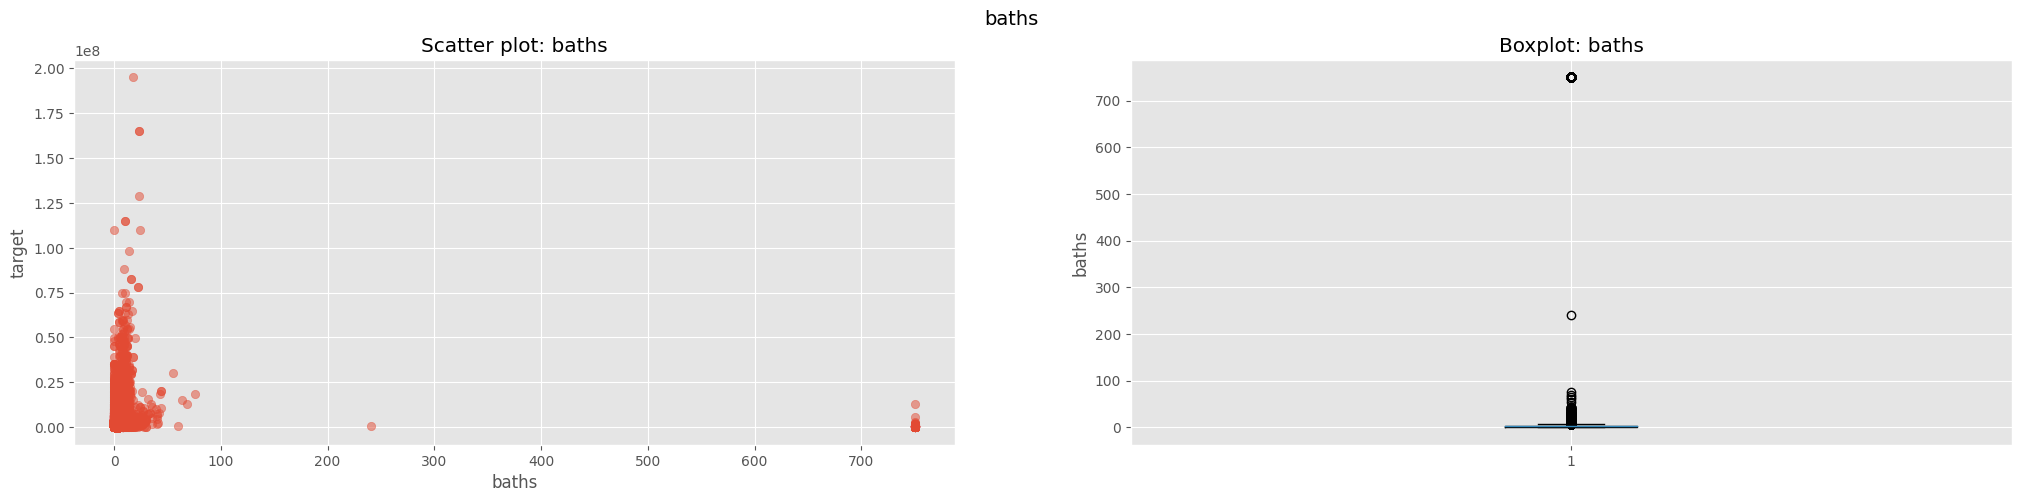

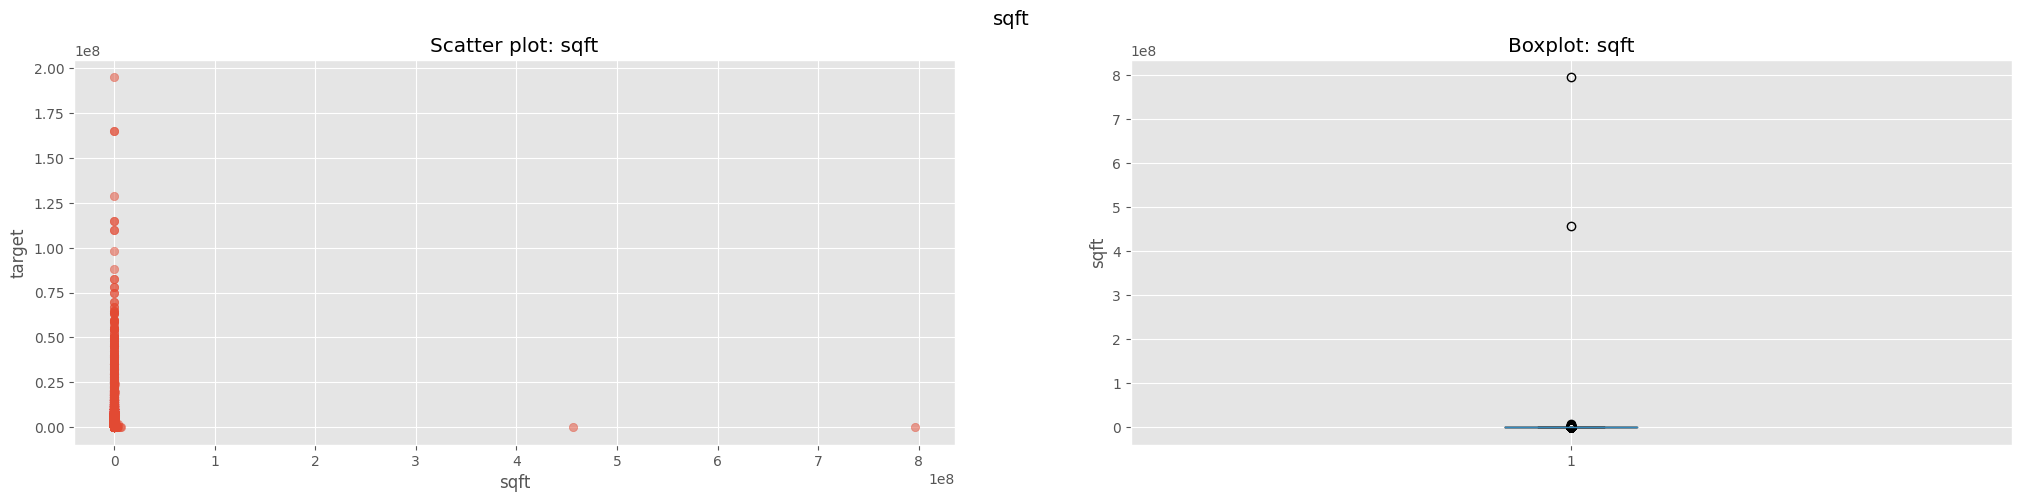

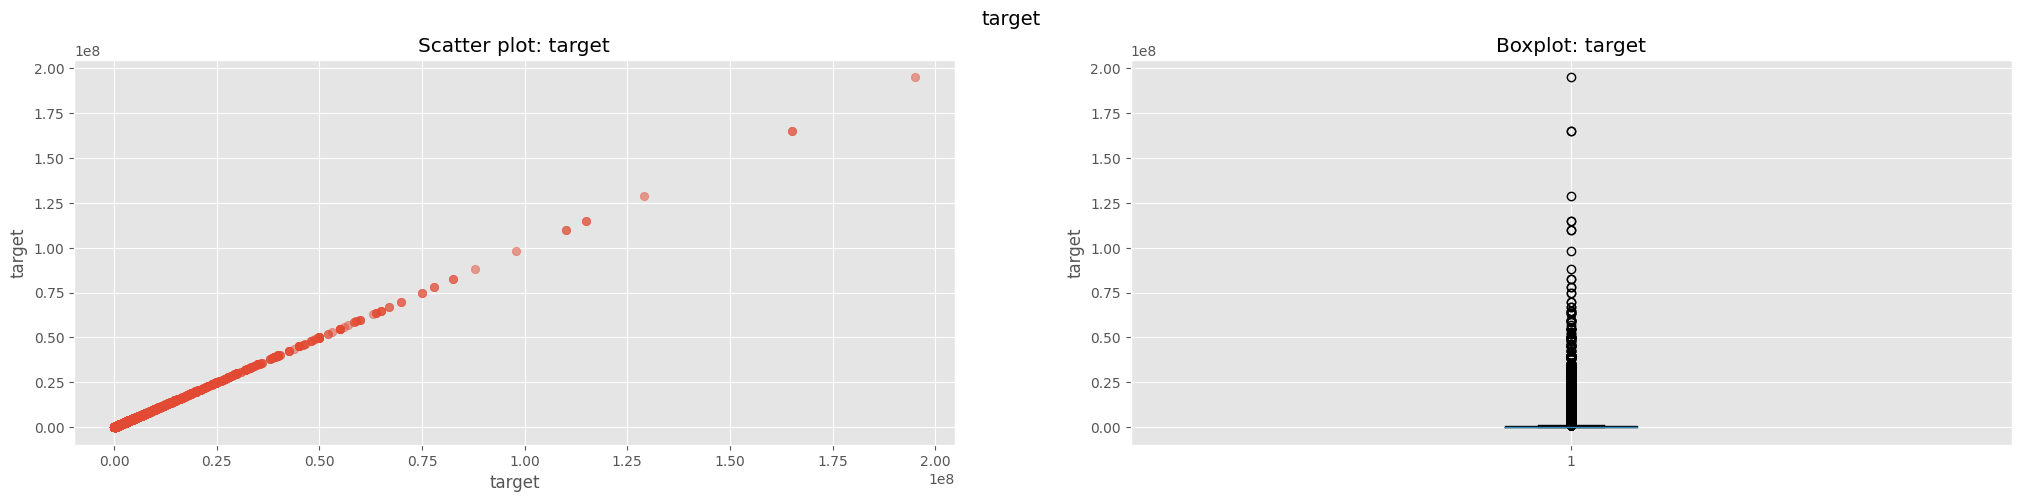

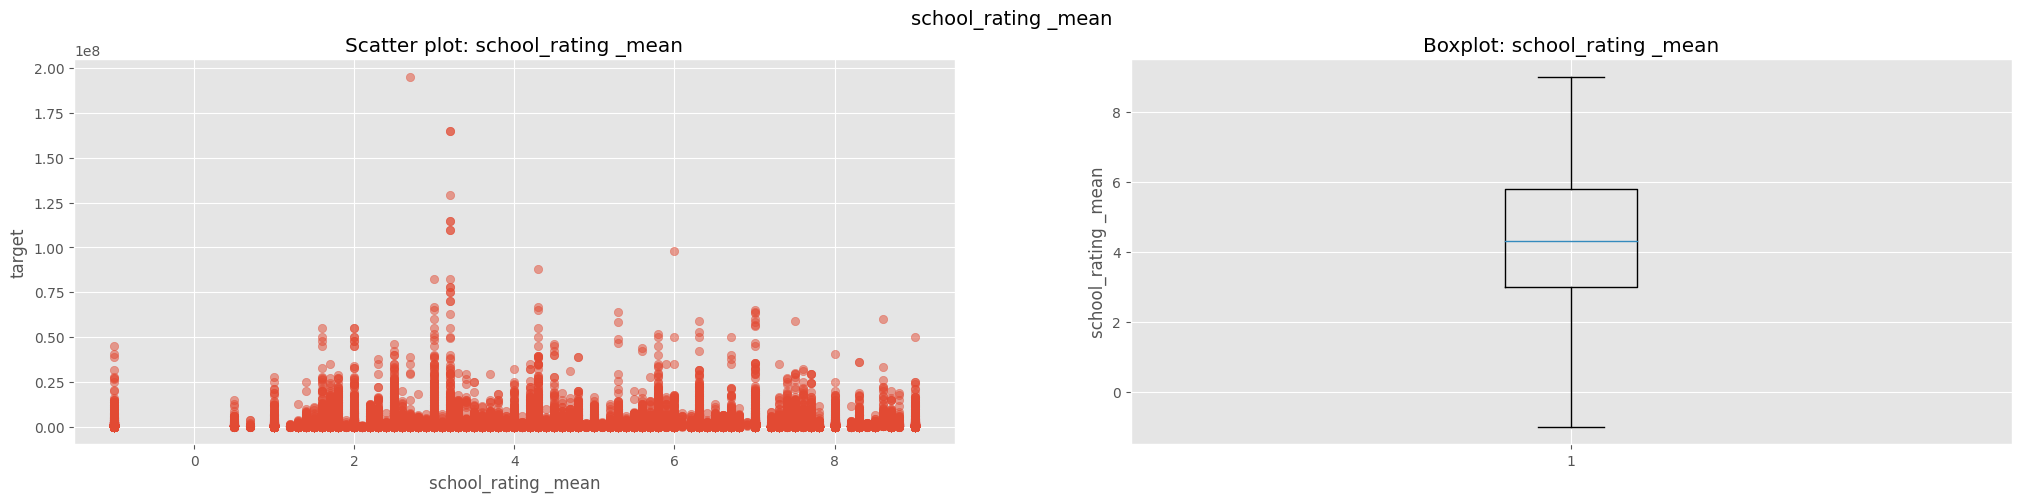

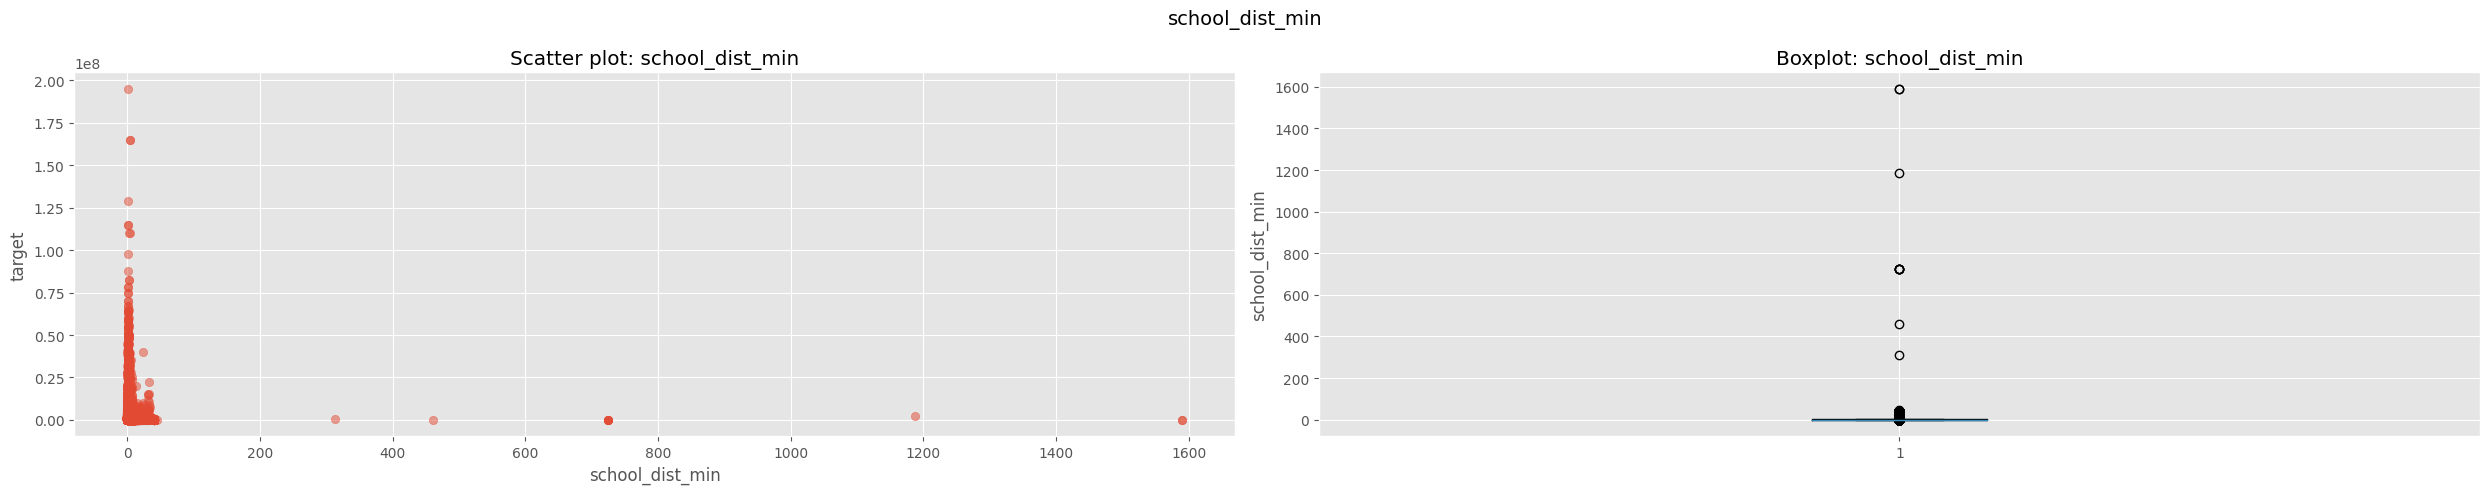

In [107]:
for feature in digital_features:
    fig, (barplot,boxploot) = plt.subplots(1, 2, figsize=(25, 5)) 
    fig.suptitle(f'{feature}', fontsize=14)
      
    barplot.scatter(df[feature], df['target'], alpha=0.5)
    barplot.set_title(f'Scatter plot: {feature}')
    barplot.set_xlabel(feature)
    barplot.set_ylabel('target')
    
    boxploot.boxplot(df[feature])
    boxploot.set_title(f'Boxplot: {feature}')
    boxploot.set_ylabel(feature)
    
plt.tight_layout()

In [108]:
# Удалим значения признака baths > 25
mask = (df['baths']>25)
print(mask.sum())
df = df[~mask]

279


In [109]:
# Подбираем маску для признака sqft
mask = (df['sqft'] > 30000)
print(mask.sum())
df = df[~mask]

1256


In [110]:
# Подбираем маску для признака target
mask = (df['target'] > 1000000)
print(mask.sum())
df = df[~mask]

37112


In [111]:
# Подбираем маску для признака school_dist_min
mask = (df['school_dist_min'] < 0) | (df['school_dist_min'] > 20)
print(mask.sum())
df = df[~mask]

2929


In [112]:
# Подбираем маску для признака school_rating _mean
mask = (df['school_rating _mean'] < 0)
print(mask.sum())
df = df[~mask]

689


In [113]:
# Удалим строки где sqft = 0 и количество baths >= 1
mask = ((df['baths'] >= 1) & (df['sqft'] < 1))
print(mask.sum())
df = df[~mask]

3412


In [114]:
# Удалим строки где sqft = 0 так как ранее мы удалили признак размера земельного участка
# Так же полностью удалим все данные с типом land, т.к. не сможем сделать по ним нормальный прогноз
# Мера не очень, но оптимизировать все правильно нет возможности
mask = ((df['sqft'] < 1) | (df['propertyType'] == 'land'))
print(mask.sum())
df = df[~mask]

8241


In [115]:
# Количество уникальных значений в категориальных признаках
# Уменьшим количество узначений что бы упростить обучение моделей
# Вынужденная мера которую не стоило бы применять при коммерческой работе.
print("Статус: ", df.status.nunique())
print("Тип недвижимости: ", df.propertyType.nunique())
print("Город: ", df.city.nunique())
print("Индекс: ", df.zipcode.nunique())
print("Штат:", df.state.nunique())
print("Год постройки: ", df['Year built'].nunique())


Статус:  13
Тип недвижимости:  11
Город:  1738
Индекс:  4052
Штат: 35
Год постройки:  208


In [116]:
counts = df['zipcode'].value_counts()
df = df.loc[df['zipcode'].isin(counts.index[counts > 50])]
df['zipcode'].value_counts().tail(10)

zipcode
45238    51
84117    51
97233    51
75009    51
11379    51
14221    51
31792    51
60645    51
97213    51
84111    51
Name: count, dtype: int64

In [117]:
counts = df['city'].value_counts()
df = df.loc[df['city'].isin(counts.index[counts > 10])]
df['city'].value_counts().tail(10)

city
Federal Heights        13
Anderson Twp           13
BELLE ISLE             12
St. Petersburg         11
Baldwin                11
Springfield Gardens    11
Briarwood              11
Brown Deer             11
Buena Ventura Lakes    11
Sweetwater             11
Name: count, dtype: int64

In [118]:
counts = df['Year built'].value_counts()
df = df.loc[df['Year built'].isin(counts.index[counts > 10])]
df['Year built'].value_counts().tail(10)

Year built
1891    33
1886    27
2021    26
1889    25
1888    16
1897    16
1850    13
1860    13
1883    12
1887    11
Name: count, dtype: int64

In [119]:
counts = df['state'].value_counts()
df = df.loc[df['state'].isin(counts.index[counts > 10])]
df['state'].value_counts().tail(10)

state
AZ    2397
IN    1799
OR    1413
WI     398
UT     325
NJ     189
MD     174
MO     118
VT      64
VA      53
Name: count, dtype: int64

In [120]:
counts = df['status'].value_counts()
df = df.loc[df['status'].isin(counts.index[counts > 10])]
df['status'].value_counts().tail(10)

status
Active            59213
Other             29083
Foreclosure        6511
Pending            4316
Under Contract     2261
Contingent          734
Price Change        380
Auction             149
Back on Market       89
Coming Soon          48
Name: count, dtype: int64

In [121]:
# Количество уникальных значений после обработки
print("Статус: ", df.status.nunique())
print("Тип недвижимости: ", df.propertyType.nunique())
print("Город: ", df.city.nunique())
print("Индекс: ", df.zipcode.nunique())
print("Штат:", df.state.nunique())
print("Год постройки: ", df['Year built'].nunique())

Статус:  11
Тип недвижимости:  11
Город:  527
Индекс:  1421
Штат: 25
Год постройки:  144


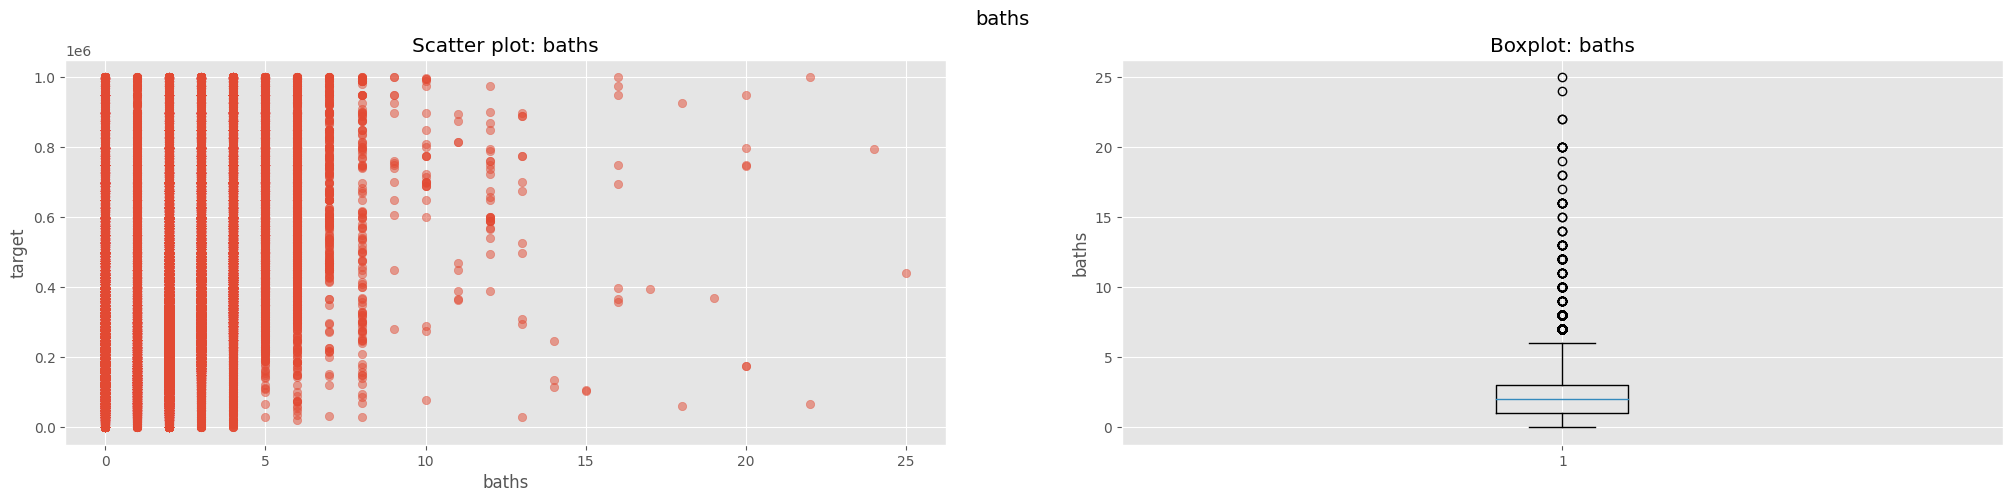

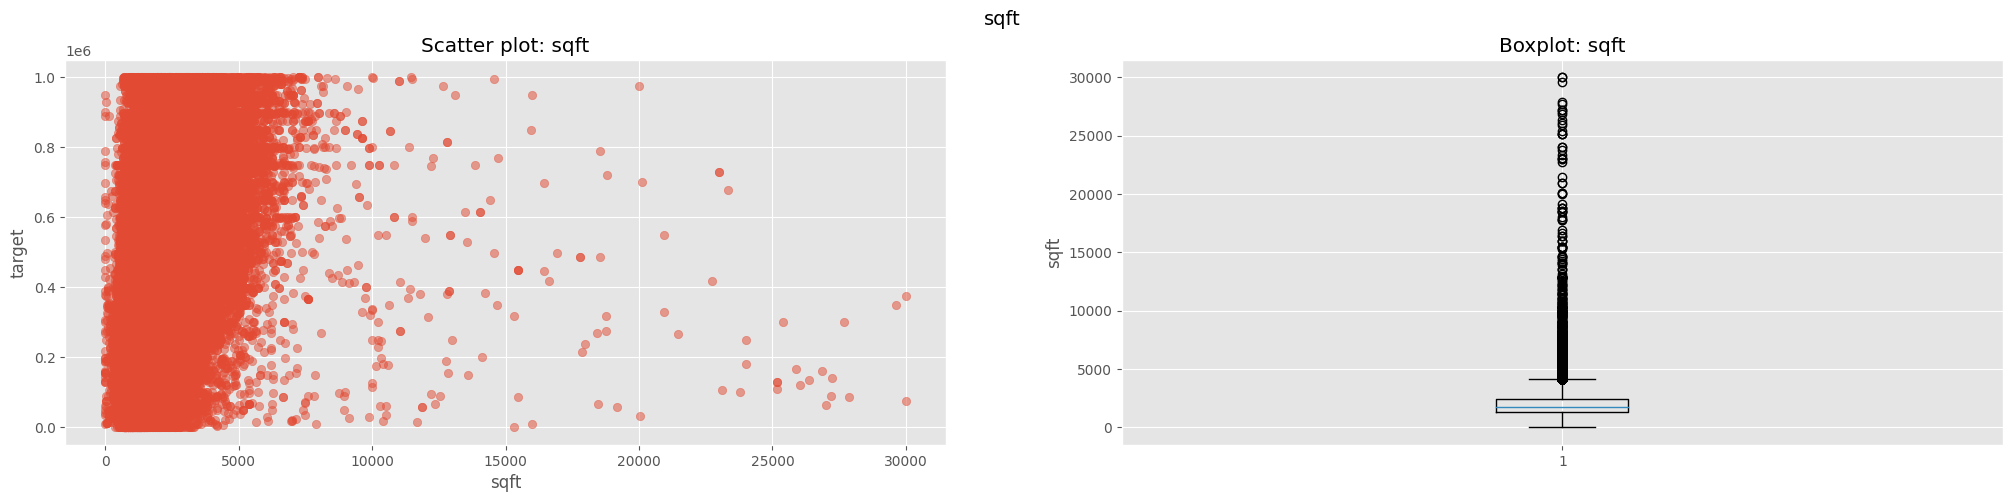

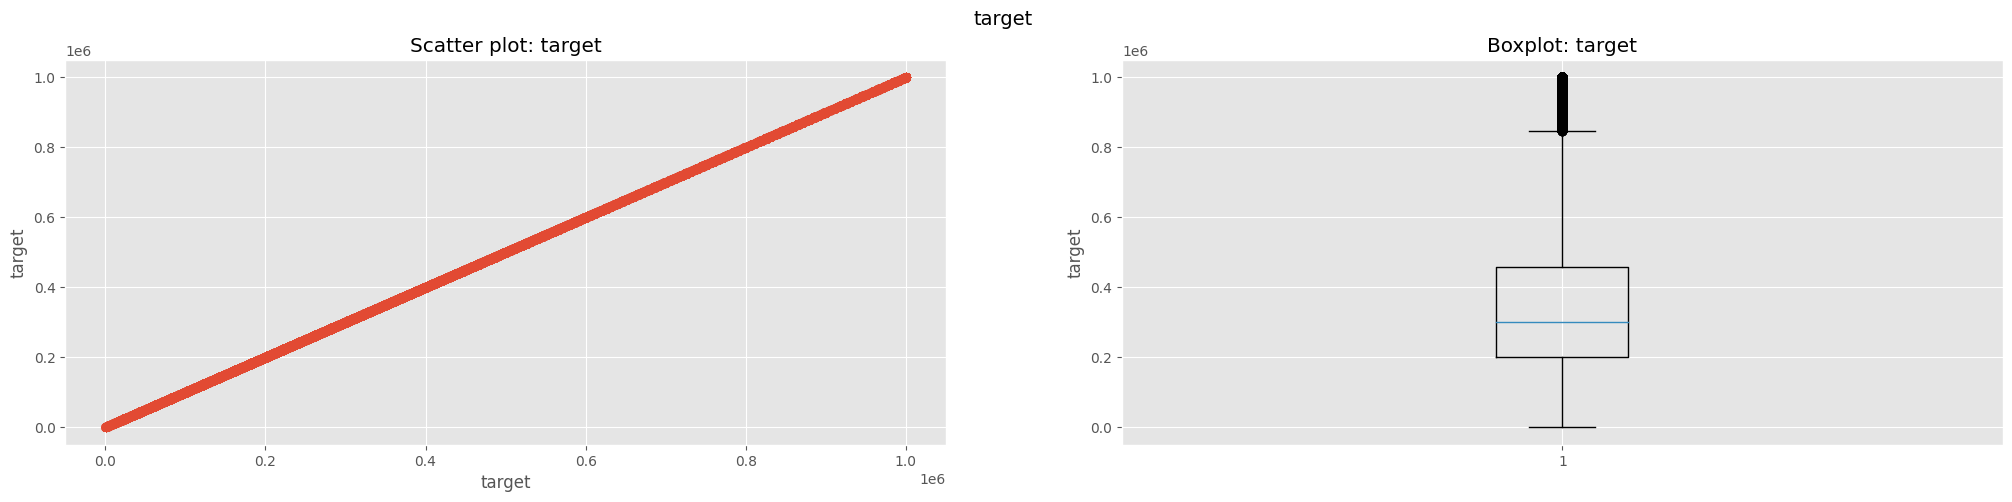

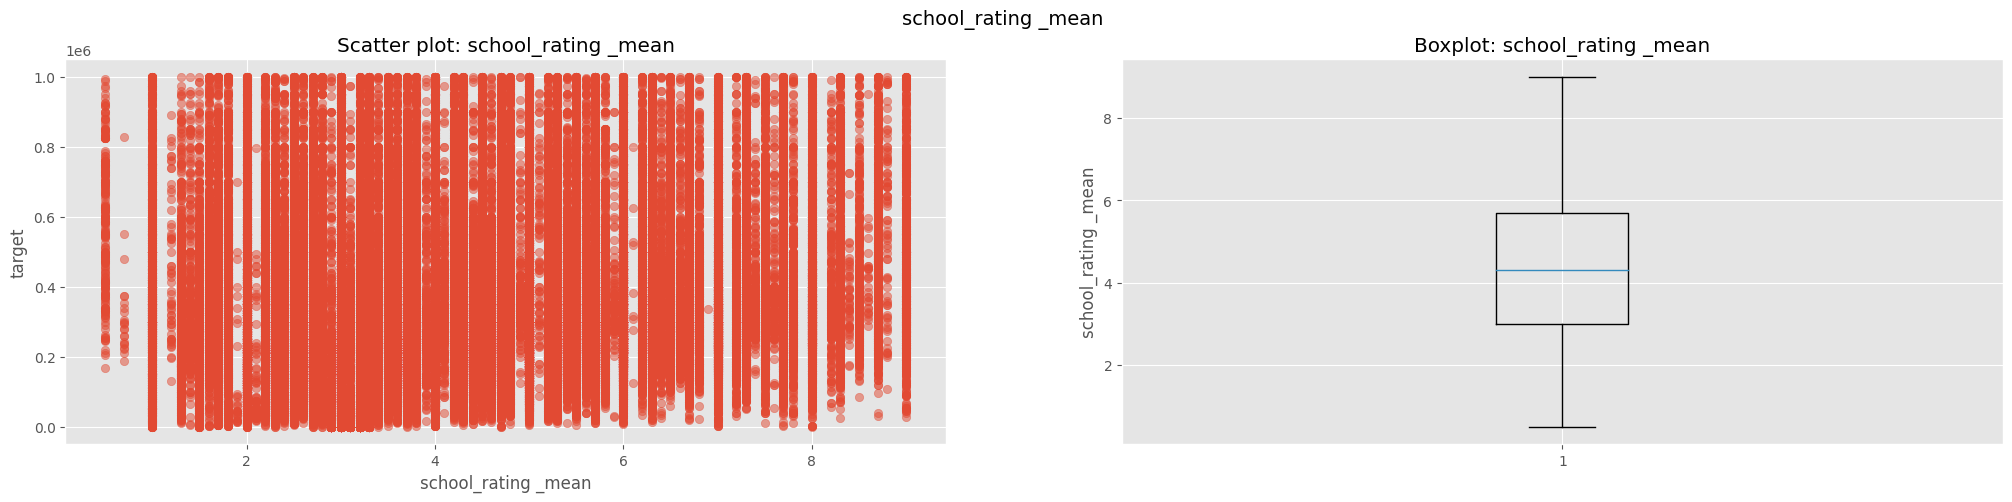

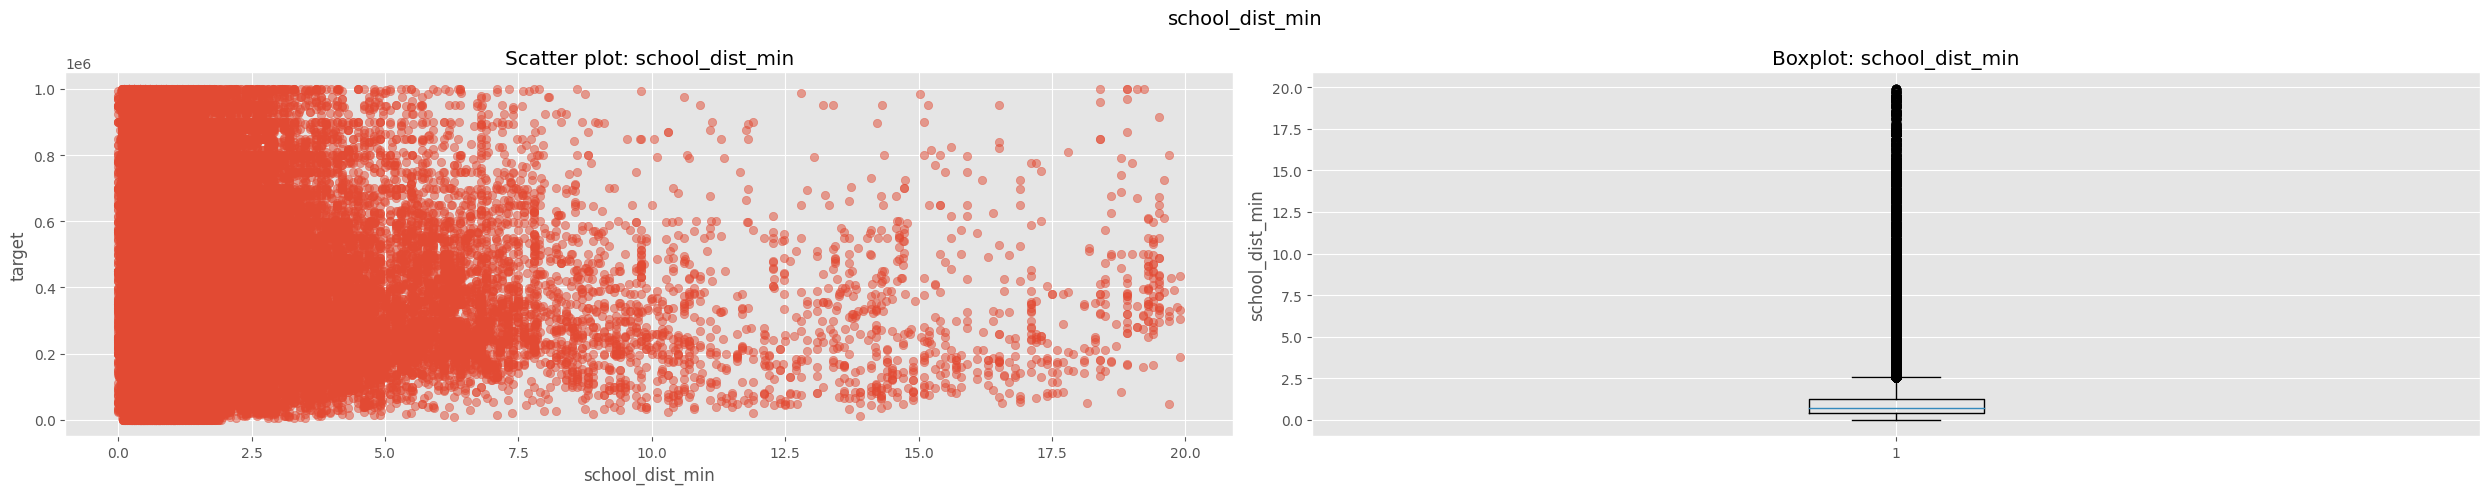

In [122]:
# Посмотрим что получилось
for feature in digital_features:
    fig, (barplot,boxploot) = plt.subplots(1, 2, figsize=(25, 5)) 
    fig.suptitle(f'{feature}', fontsize=14)
      
    barplot.scatter(df[feature], df['target'], alpha=0.5)
    barplot.set_title(f'Scatter plot: {feature}')
    barplot.set_xlabel(feature)
    barplot.set_ylabel('target')
    
    boxploot.boxplot(df[feature])
    boxploot.set_title(f'Boxplot: {feature}')
    boxploot.set_ylabel(feature)
    
plt.tight_layout()

In [123]:
# Строим линейную регрессию для выбранных признаков
#data_selected = df[digital_features]
#sns.pairplot(data_selected, kind='reg')
#Добавляем заголовок
#plt.title('Линейная регрессия для выбранных признаков')
# Сохраняем график в файл с расширением PNG
#plt.savefig('images/plot.png', format='png')
#plt.show()

![title](images/plot.png)

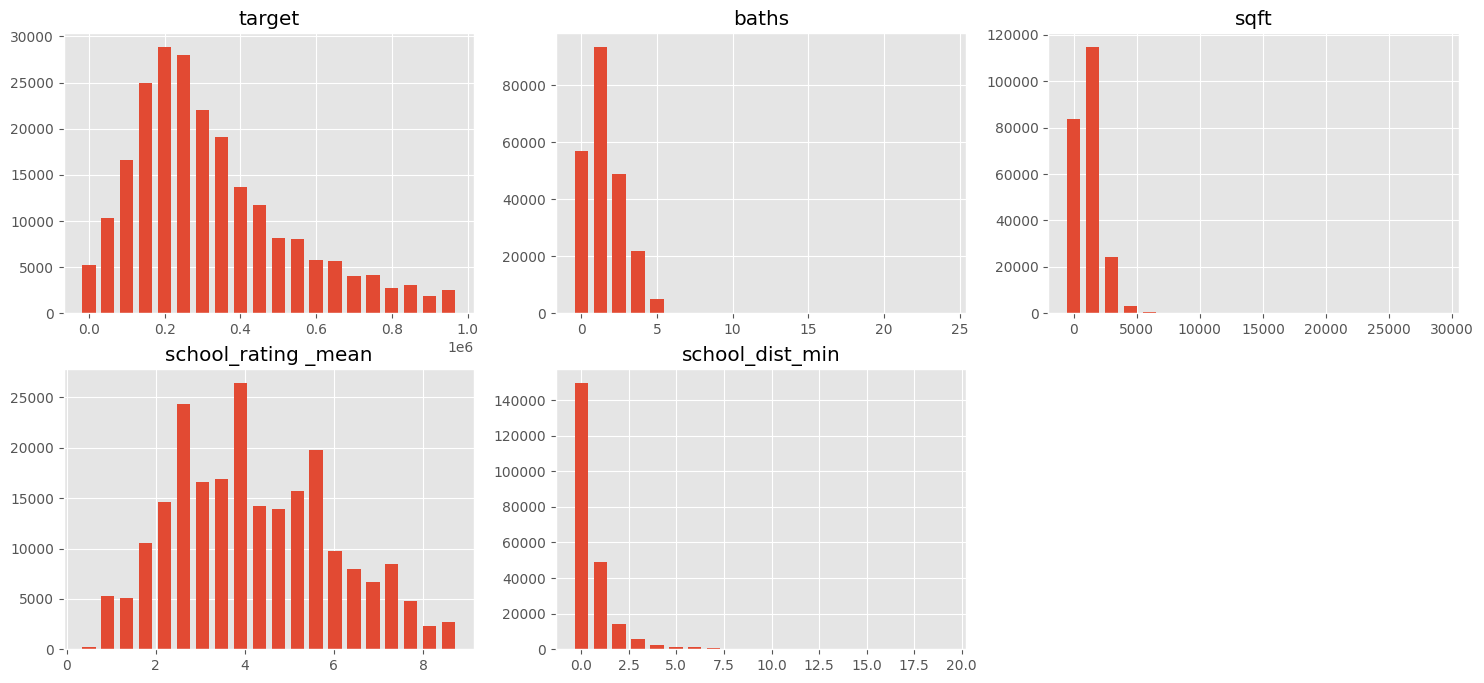

In [124]:
# посмотрим числовые признаки на нормальность распределения
def visnormaldistrib(values):
  columns = min(3, len(values))
  rows = (len(values) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(values.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()
  
visnormaldistrib({'target': df['target'], 'baths': df['baths'],'sqft': df['sqft'],'school_rating _mean': df['school_rating _mean'],'school_dist_min': df['school_dist_min'],})
# числовые признаки необходимо будет нормализовть и логорифмировать для получения нормального распределения.

Ранг матрицы корреляций: 5
Определитель матрицы корреляций: 0.5465599


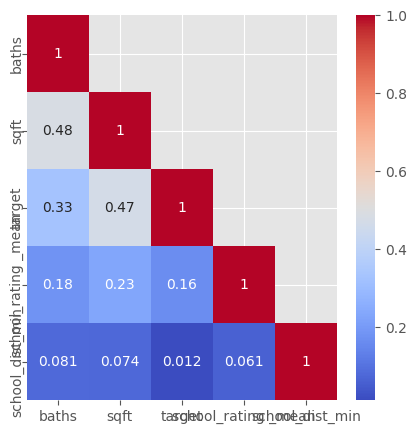

In [125]:
# Проверяем на мультиколлинеарность и корреляцию числовых признаков между собой и с главным признаком "target":
# строим матрицу корреляций
corr_matrix = np.corrcoef(df[digital_features], rowvar=False)
print('Ранг матрицы корреляций:', np.linalg.matrix_rank(corr_matrix))
print('Определитель матрицы корреляций: {:.7f}'.format(np.linalg.det(corr_matrix)))

# формируем нижний треугольник матрицы корреляций
corr_matrix_tril = np.tril(corr_matrix)
# заполняем верхний треугольник значениями NaN
corr_matrix_tril[corr_matrix_tril == 0] = np.nan

# создаем фигуру с автоматическим масштабированием
plt.figure(figsize=(len(df[digital_features].columns), len(df[digital_features].columns)))

# строим тепловую карту
sns.heatmap(corr_matrix_tril, annot=True, cmap='coolwarm', mask=np.isnan(corr_matrix_tril))
# добавляем подписи столбцов на тепловой карте
plt.xticks(np.arange(len(df[digital_features].columns))+0.5, df[digital_features].columns, rotation=0, ha='center', fontsize=10)
plt.yticks(np.arange(len(df[digital_features].columns))+0.5, df[digital_features].columns, ha='center', fontsize=10, va='center', rotation=90)
# отображаем график
plt.show()
# Мультиколлинеарность отсутствует

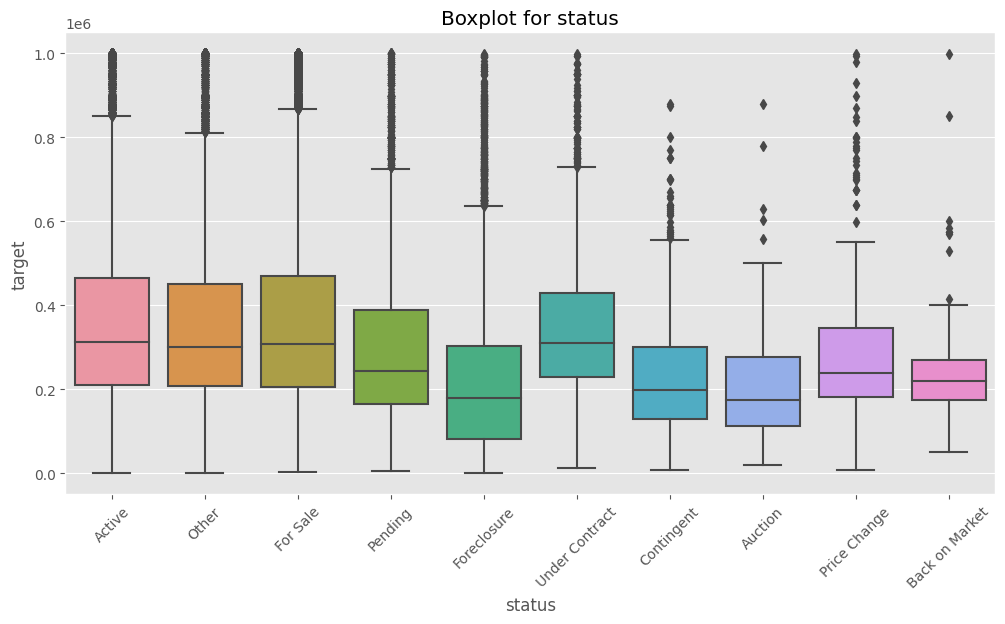

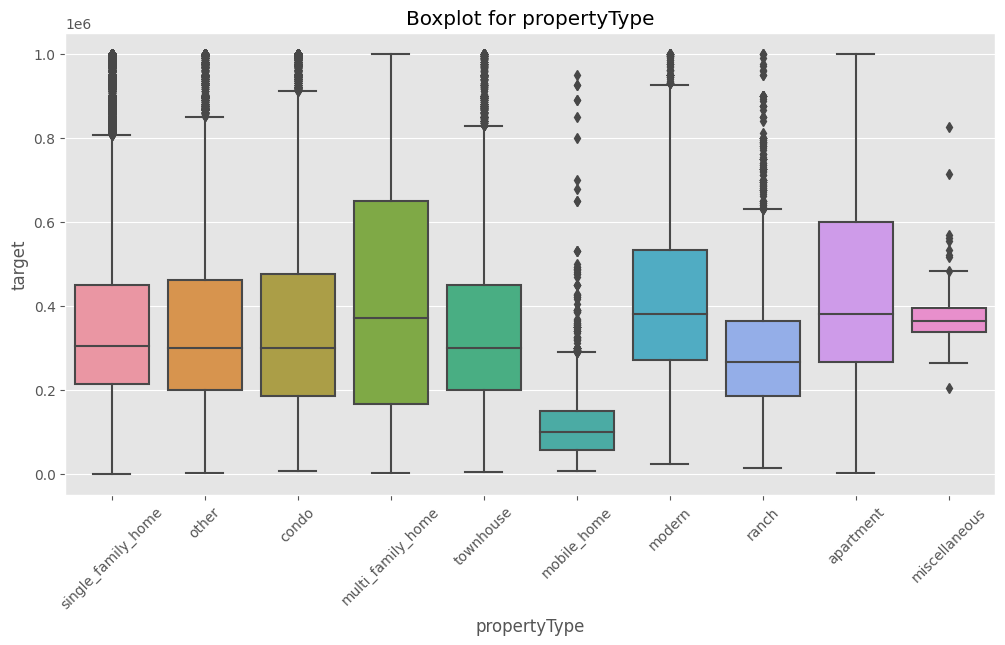

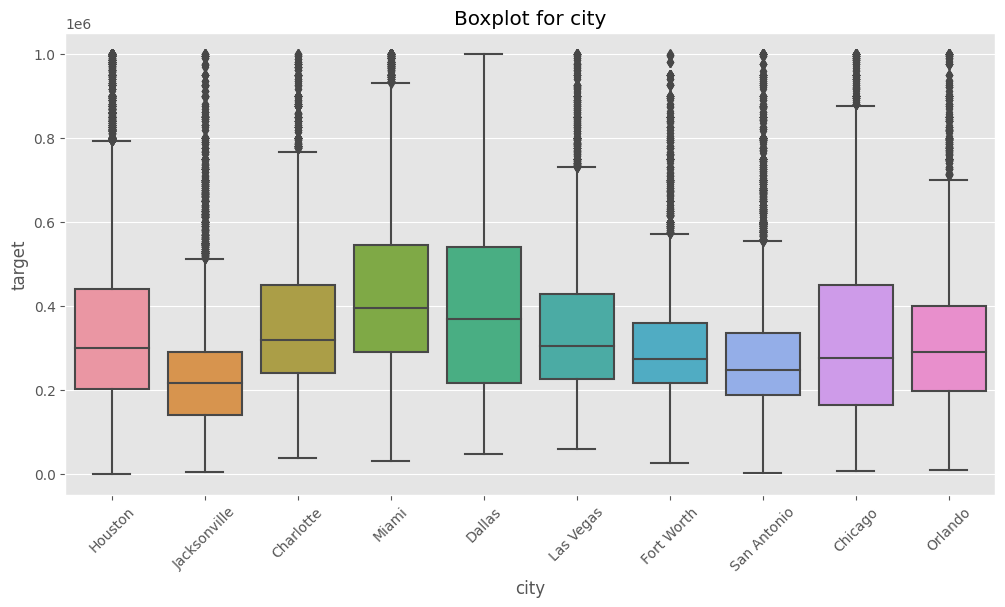

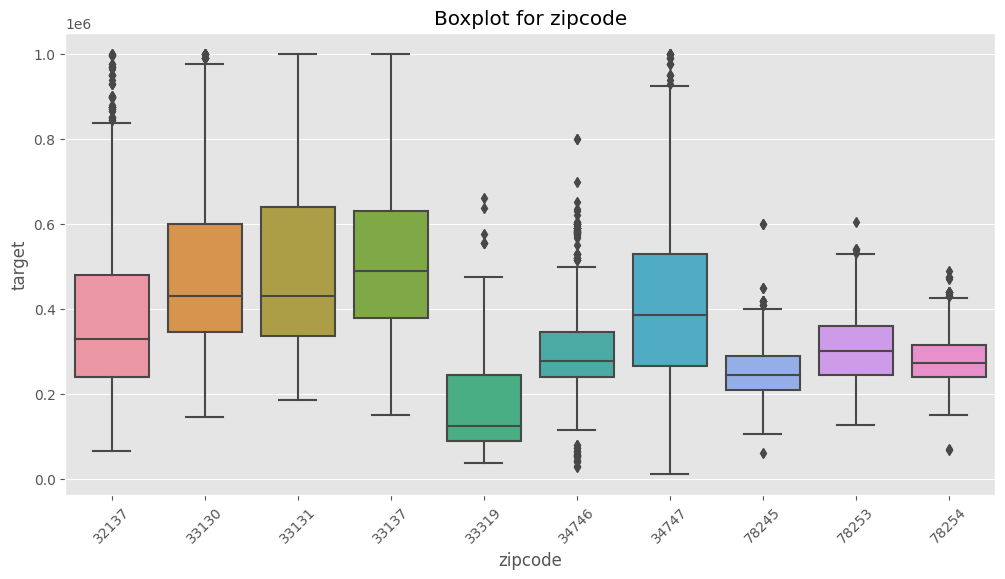

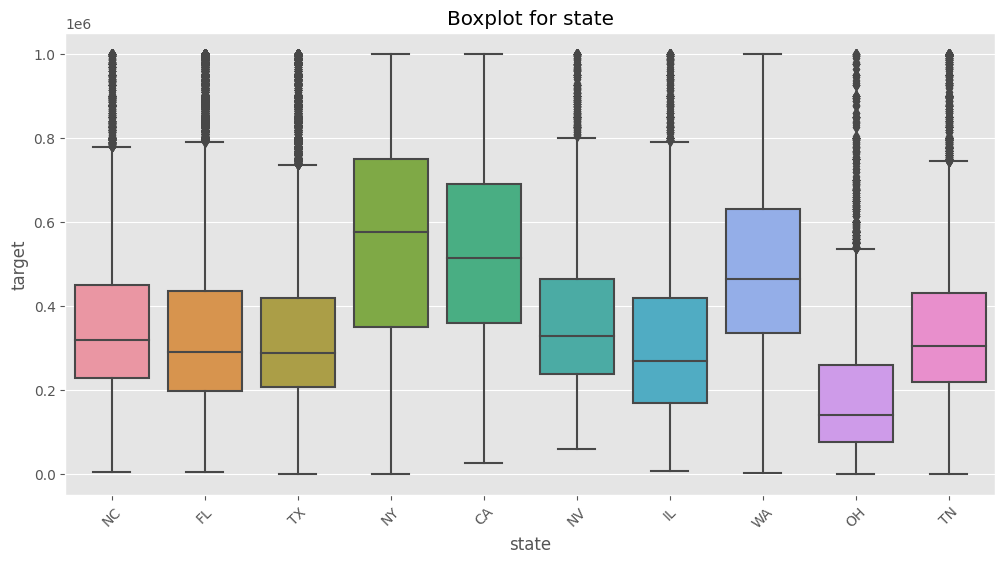

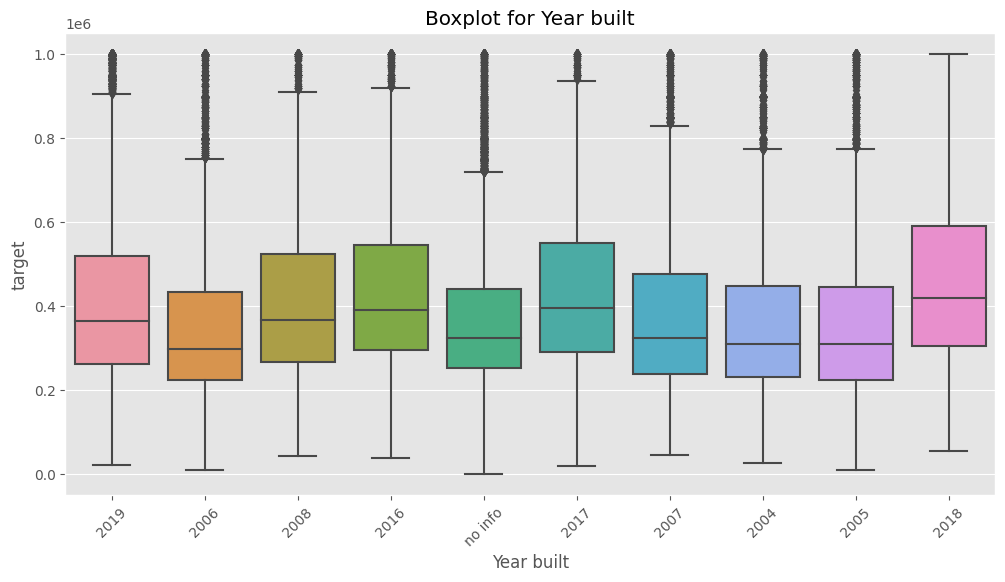

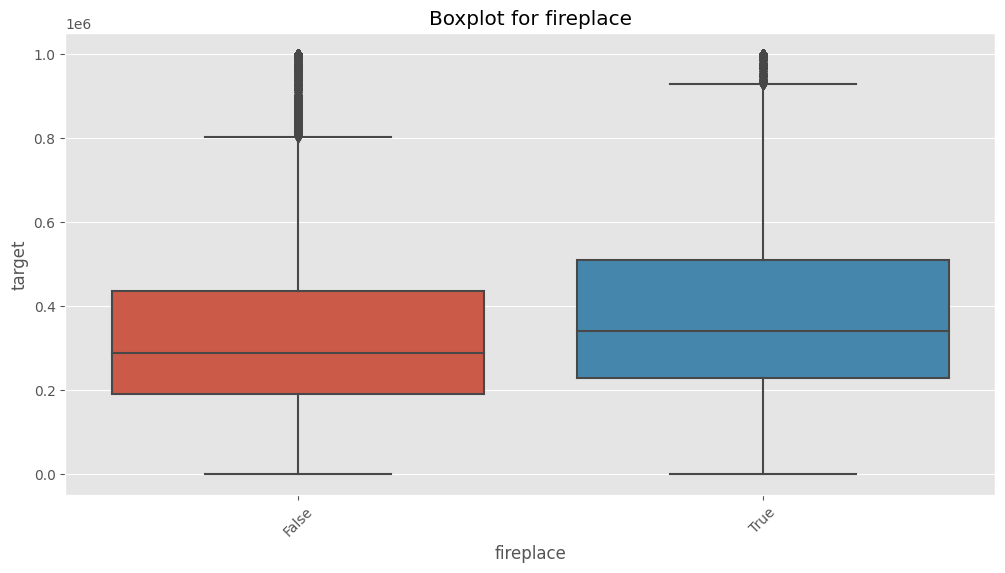

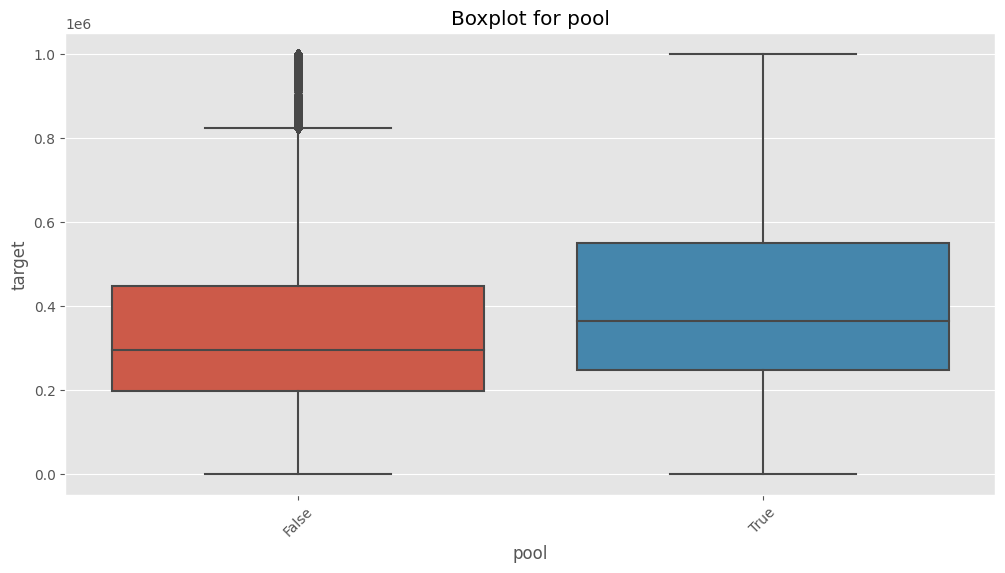

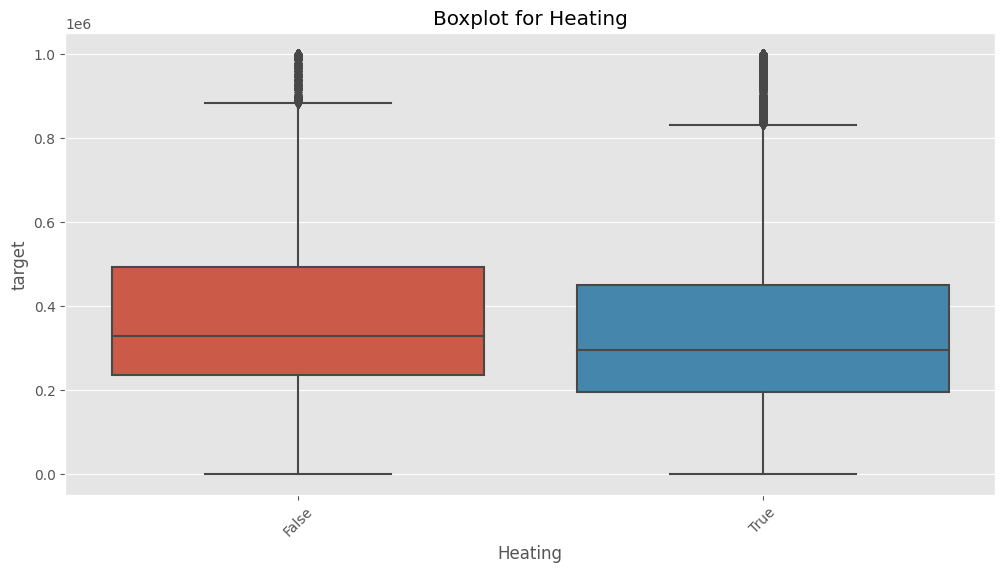

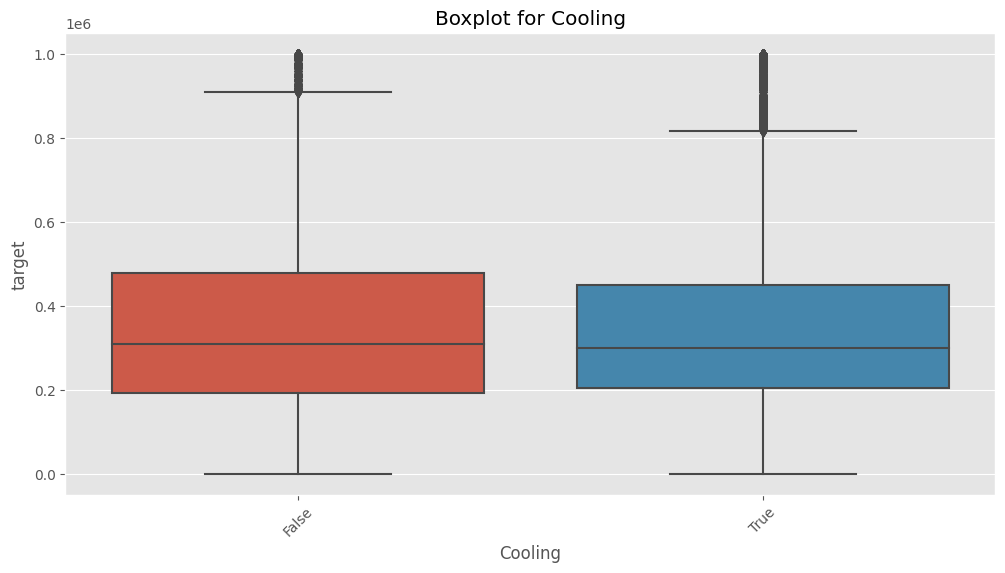

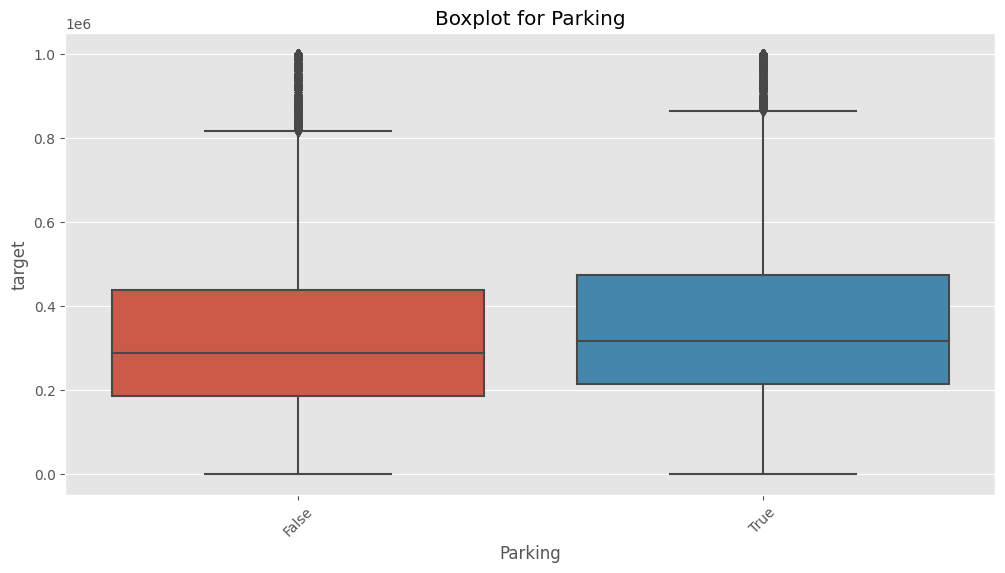

In [129]:
# Посмотрим на распределение стоймости квартир в зависимости от значения категориальных переменных
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.boxplot(x=column, y='target', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

for col in chain(categorial_features, binar_features):
    get_boxplot(col)

In [130]:
df.head(5)

,status,propertyType,baths,fireplace,city,sqft,zipcode,state,target,pool,Year built,Heating,Cooling,Parking,school_rating _mean,school_dist_min
0,Active,single_family_home,4.0,True,Southern Pines,2900,28387,NC,418000,False,2019,True,False,False,5.2,2.7
5,Active,other,0.0,False,POINCIANA,1507,34759,FL,181500,False,2006,True,True,False,2.3,0.8
8,Other,single_family_home,3.0,False,Houston,1930,77080,TX,311995,False,2019,True,True,True,3.0,0.6
9,For Sale,condo,2.0,False,Flushing,1300,11354,NY,669000,False,1965,False,False,True,2.8,0.3
10,Active,other,0.0,False,Houston,3130,77068,TX,260000,False,2015,True,True,False,4.2,0.4


In [131]:
# Сохраним датасет с нормализованными данными
df.to_csv('data/data_normolized.csv', index=False)

## 4. КОДИРОВАНИЕ ПРИЗНАКОВ И ОБУЧЕНИЕ МОДЕЛИ

In [2]:
import pandas as pd
import numpy as np
from itertools import chain

#from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
matplotlib.style.use('ggplot')

In [3]:
df= pd.read_csv('data/data_normolized.csv')
df.head(3)

,status,propertyType,baths,fireplace,city,sqft,zipcode,state,target,pool,Year built,Heating,Cooling,Parking,school_rating _mean,school_dist_min
0,Active,single_family_home,4.0,True,Southern Pines,2900,28387,NC,418000,False,2019,True,False,False,5.2,2.7
1,Active,other,0.0,False,POINCIANA,1507,34759,FL,181500,False,2006,True,True,False,2.3,0.8
2,Other,single_family_home,3.0,False,Houston,1930,77080,TX,311995,False,2019,True,True,True,3.0,0.6


In [4]:
df.zipcode = df.zipcode.astype(str)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226604 entries, 0 to 226603
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               226604 non-null  object 
 1   propertyType         226604 non-null  object 
 2   baths                226604 non-null  float64
 3   fireplace            226604 non-null  bool   
 4   city                 226604 non-null  object 
 5   sqft                 226604 non-null  int64  
 6   zipcode              226604 non-null  object 
 7   state                226604 non-null  object 
 8   target               226604 non-null  int64  
 9   pool                 226604 non-null  bool   
 10  Year built           226604 non-null  object 
 11  Heating              226604 non-null  bool   
 12  Cooling              226604 non-null  bool   
 13  Parking              226604 non-null  bool   
 14  school_rating _mean  226604 non-null  float64
 15  school_dist_min  

In [6]:
# У нас присутствуют булевые, числовые, и категориальные признаки. Составим списки признаков по типу данных
digital_features = ['baths', 'sqft', 'target', 'school_rating _mean', 'school_dist_min']

binar_features = ['fireplace', 'pool', 'Heating', 'Cooling', 'Parking']

categorial_features = ['status', 'propertyType', 'city', 'zipcode', 'state', 'Year built']

### 4.1. Кодируем признаки

In [7]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df.copy()
    # переведем признак зип кода в категориальный
    df_output['zipcode'] = df_output['zipcode'].astype(str)
    # переведем признак год в категориальный
    df_output['Year built'] = df_output['Year built'].astype(str)
    # Нормализация и логорифмирование данных
    #scaler = MinMaxScaler()
    for column in ['baths', 'sqft', 'target', 'school_rating _mean', 'school_dist_min']:
        #df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
        # Логорифмирование
        df_output[column] = df_output[column].apply(lambda x: abs(x))
        constant = 1e-6
        df_output[column] = np.log(df_output[column] + constant)
        
    # ################### Categorical Features ############################################################## 
 
    ohe_status = OneHotEncoder(sparse=False)
    ohe_state = OneHotEncoder(sparse=False)
    ohe_Type = OneHotEncoder(sparse=False)

    status_ohe = ohe_status.fit_transform(df_output['status'].values.reshape(-1,1))
    state_ohe = ohe_state.fit_transform(df_output['state'].values.reshape(-1,1))
    Type_ohe = ohe_Type.fit_transform(df_output['propertyType'].values.reshape(-1,1))

    le = LabelEncoder()
    state_label = le.fit_transform(df_output['state'])

    year_le = LabelEncoder()
    year_ord = year_le.fit_transform(df_output['Year built'])

    city_le = LabelEncoder()
    city_label = city_le.fit_transform(df_output['city'])

    zip_le = LabelEncoder()
    zip_label = zip_le.fit_transform(df_output['zipcode'])

    # Adding encoded categorical features to the output dataframe
    df_output = df_output.join(pd.DataFrame(status_ohe, columns=['status_' + str(cat) for cat in ohe_status.categories_[0]]))
    df_output = df_output.join(pd.DataFrame(state_ohe, columns=['state_' + str(cat) for cat in ohe_state.categories_[0]]))
    df_output = df_output.join(pd.DataFrame(Type_ohe, columns=['Type_' + str(cat) for cat in ohe_Type.categories_[0]]))
    df_output['state_label'] = state_label
    df_output['year_ord'] = year_ord
    df_output['city_label'] = city_label
    df_output['zip_label'] = zip_label

    # Dropping original categorical columns
    df_output.drop(['status', 'state', 'propertyType', 'city', 'zipcode','Year built'], axis=1, inplace=True)
    
    return df_output

In [8]:
# Запускаем и проверяем, что получилось
df_encoded = preproc_data(df)
df_encoded.sample(10)

c:\Users\velho\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\velho\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\velho\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,baths,fireplace,sqft,target,pool,Heating,Cooling,Parking,school_rating _mean,school_dist_min,...,Type_modern,Type_multi_family_home,Type_other,Type_ranch,Type_single_family_home,Type_townhouse,state_label,year_ord,city_label,zip_label
77914,1.098613,False,7.603399,11.125791,False,True,False,False,0.916291,-1.237871,...,0.0,1.0,0.0,0.0,0.0,0.0,15,21,85,675
186854,0.693148,True,7.416378,12.287192,False,True,False,True,0.916291,-0.597835,...,0.0,0.0,0.0,0.0,1.0,0.0,5,85,15,229
186044,0.693148,False,7.825245,12.517190,False,False,False,False,1.757858,0.095311,...,0.0,0.0,0.0,0.0,1.0,0.0,0,143,60,1191
74627,0.693148,False,7.130899,11.406453,False,True,True,False,0.832910,-0.510824,...,0.0,0.0,0.0,0.0,1.0,0.0,15,84,269,699
219271,-13.815511,False,7.044905,12.254863,False,False,False,True,1.902108,-0.994250,...,0.0,0.0,0.0,0.0,0.0,0.0,20,85,197,1181
35174,0.693148,False,7.757051,12.283348,False,True,True,False,1.547563,0.993252,...,0.0,0.0,0.0,0.0,1.0,0.0,4,126,215,263
220055,0.693148,False,6.768493,12.180755,False,True,True,True,1.280934,-0.210720,...,0.0,0.0,0.0,0.0,0.0,0.0,4,124,117,413
83853,-13.815511,False,8.458928,13.444447,False,True,True,False,0.693148,0.405466,...,0.0,0.0,0.0,0.0,1.0,0.0,4,128,105,397
164210,0.693148,False,7.705262,12.323411,False,True,True,False,1.386295,0.693148,...,0.0,0.0,0.0,0.0,1.0,0.0,4,126,320,555
186297,1.386295,True,8.285513,13.384574,False,True,True,False,1.791760,1.071584,...,0.0,0.0,0.0,0.0,1.0,0.0,5,106,414,244


In [9]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226604 entries, 0 to 226603
Data columns (total 61 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   baths                    226604 non-null  float64
 1   fireplace                226604 non-null  bool   
 2   sqft                     226604 non-null  float64
 3   target                   226604 non-null  float64
 4   pool                     226604 non-null  bool   
 5   Heating                  226604 non-null  bool   
 6   Cooling                  226604 non-null  bool   
 7   Parking                  226604 non-null  bool   
 8   school_rating _mean      226604 non-null  float64
 9   school_dist_min          226604 non-null  float64
 10  status_Active            226604 non-null  float64
 11  status_Auction           226604 non-null  float64
 12  status_Back on Market    226604 non-null  float64
 13  status_Coming Soon       226604 non-null  float64
 14  stat

### 4.2. Создаем "наивную" модель

In [10]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
TEST_SIZE = 0.2

In [11]:
y = df_encoded.target.values
X = df_encoded.drop(['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

Создадим "наивную" модель. Эта модель будет предсказывать среднюю стоимость по общей площади и городу

In [12]:
# Наивная модель
class NaiveModel:
    def __init__(self):
        self.means = None

    def fit(self, X, y):
        X_df = pd.DataFrame(X, columns=['city_label'])
        y_df = pd.DataFrame(y, columns=['target'])
        df = pd.concat([X_df, y_df], axis=1)
        self.means = df.groupby(['city_label'])['target'].mean().reset_index()

    def predict(self, X):
        X = pd.DataFrame(X, columns=['city_label']).copy()
        X['mean'] = np.nan
        for idx, row in self.means.iterrows():
            X.loc[(X['city_label'] == row['city_label']), 'mean'] = row['target']
        
        X['mean'].fillna(X['mean'].mean(), inplace=True)
        return X['mean'].to_numpy()

naive_model = NaiveModel()
naive_model.fit(X_train, y_train)
y_pred_train = naive_model.predict(X_train)
y_pred_test = naive_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.58
Test MSE: 0.59
Train MAE: 0.53
Test MAE: 0.54
Train R2: 0.00
Test R2: 0.00


MAE (Средняя абсолютная ошибка, Mean Absolute Error) - это мера ошибки, вычисленная как среднее значение абсолютных значений ошибок. Меньшие значения MAE указывают на лучшую точность модели.
MSE — средний квадрат ошибки определения какой-либо величины, квадратный корень из MSE есть среднеквадратическое отклонение определяемой величины от её математического ожидания.
Значения MSE и MAE, как для обучающей, так и для тестовой выборок, очень высоки и почти одинаковы Это говорит о низкой точности модели. Модель демонстрирует схожую производительность на обеих выборках и не страдает от явного переобучения или недообучения.
Значения R^2 близки к нулю, что говорит о том, что модель слабо объясняет зависимость между переменными. Это может свидетельствовать о низкой предсказательной способности модели

### 4.3. Модель LinearRegression

In [13]:
# создаём модель линейной регрессии
model = LinearRegression(fit_intercept=False)

# вычисляем коэффициенты регрессии
model.fit(X_train, y_train)

# делаем предсказания с помощью модели
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# вычисляем требуемые метрики
mse_train = metrics.mean_squared_error(y_train, y_train_pred)
mse_test = metrics.mean_squared_error(y_test, y_test_pred)
mae_train = metrics.mean_absolute_error(y_train, y_train_pred)
mae_test = metrics.mean_absolute_error(y_test, y_test_pred)
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test = metrics.r2_score(y_test, y_test_pred)

# выводим метрики
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.27
Test MSE: 0.28
Train MAE: 0.38
Test MAE: 0.38
Train R2: 0.53
Test R2: 0.53


Результаты модели показывают, что она работает с одинаковой точностью на обучающем и тестовом наборе данных, что свидетельствует о том, что модель не переобучилась. Коэффициент детерминации R2 низкий и указывает на то, что предсказательнная способность модели невелика.

### 4.4. Модель RandomForestRegressor

In [15]:
# Создаем экземпляр модели RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=RANDOM_SEED)

# Обучаем модель на обучающих данных
rf_regressor.fit(X_train, y_train)

# Предсказания на обучающих и тестовых данных
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Вычисляем метрики
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Выводим метрики
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.01
Test MSE: 0.07
Train MAE: 0.06
Test MAE: 0.16
Train R2: 0.98
Test R2: 0.88


In [17]:
# Не удалось подобрать гиперпараметры для модели RandomForestRegressor

#from sklearn.model_selection import GridSearchCV
#grid_space={'max_depth':[50,100,150,None],
#              'n_estimators':[50,100,150],
#              'max_features':[1,3,5,7],
#              'min_samples_leaf':[1,2,3],
#              'min_samples_split':[1,2,3]
#           }
#grid = GridSearchCV(rf_regressor,param_grid=grid_space,cv=3,scoring='accuracy')
#model_grid = grid.fit(X_train, y_train)

Значения MSE и MAE ниже на тренировочных данных, значение R2 выше на тренировочных данных, модель явно переобучилась.
Вцелом модель показала хорошие результаты и при подборе параметров может их еще улучшить

### 4.5. Модель ElasticNetCV

In [14]:
# Создаем и тренируем модель ElasticNetCV с кросс-валидацией по 5 фолдам
model_el = ElasticNetCV(cv=5, random_state=RANDOM_SEED)
model_el.fit(X_train, y_train)

# Предсказания для обучающей и тестовой выборок
y_train_pred = model_el.predict(X_train)
y_test_pred = model_el.predict(X_test)

# MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# R2
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Выводим метрики
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.32
Test MSE: 0.33
Train MAE: 0.40
Test MAE: 0.41
Train R2: 0.44
Test R2: 0.45


Модель показывает результаты на уровне модели линейной ригрессии. Значения MSE и MAE в среднем диапазоне, разница между тренировочными данными и тестовыми на уровне погрешности. Значение R2 так же в среднем диапазоне. Модель показала невысокую предсказательную способность, переобучения нет.

### 4.6. Модель CatBoostRegressor

In [15]:
def log_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df.copy()
    # переведем признак зип кода в категориальный
    df_output['zipcode'] = df_output['zipcode'].astype(str)
    # переведем признак год в категориальный
    df_output['Year built'] = df_output['Year built'].astype(str)
    # Нормализация данных и логорифмирование
    #scaler = MinMaxScaler()
    for column in digital_features:
        #df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
        # Логорифмирование
        df_output[column] = df_output[column].apply(lambda x: abs(x))
        constant = 1e-6
        df_output[column] = np.log(df_output[column] + constant)
    return df_output

In [16]:
# Запускаем и проверяем, что получилось
df_log = log_data(df)
df_log.sample(5)

,status,propertyType,baths,fireplace,city,sqft,zipcode,state,target,pool,Year built,Heating,Cooling,Parking,school_rating _mean,school_dist_min
54527,Other,single_family_home,1.098613e+00,False,Jacksonville,7.820841,32222,FL,12.429216,False,2019,False,False,True,1.098613,0.405466
189499,For Sale,single_family_home,1.098613e+00,True,Raleigh,7.903227,27603,NC,12.706545,False,1994,True,True,True,1.308333,1.383791
76757,For Sale,single_family_home,-1.381551e+01,True,Jacksonville,7.173192,32205,FL,12.468437,False,1940,True,True,True,1.667707,-0.653925
180400,Other,condo,9.999995e-07,False,North Bay Village,6.633318,33141,FL,12.418357,False,1969,True,True,False,0.916291,1.029620
89057,For Sale,townhouse,1.386295e+00,False,Fort Lauderdale,7.477038,33301,FL,13.287708,False,2019,True,False,True,1.547563,-0.328503


In [17]:
y = df_log.target.values
X = df_log.drop(['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [18]:
#param_grid = {
#    'iterations': [100, 300, 500],
#    'learning_rate': [0.01, 0.03, 0.1],
#    'depth': [4, 6, 8],
#    'l2_leaf_reg': [1, 3, 5],
#}
#cb_model = CatBoostRegressor(random_seed=RANDOM_SEED, silent=True)
#grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
#grid_search.fit(X_train, y_train, cat_features=categorial_features)
#best_params = grid_search.best_params_
#best_cb_model = CatBoostRegressor(iterations=best_params['iterations'], learning_rate=best_params['learning_rate'], depth=best_params['depth'], l2_leaf_reg=best_params['l2_leaf_reg'], random_seed=RANDOM_SEED, silent=True)
#best_cb_model.fit(X_train, y_train, cat_features=categorial_features)
#
#y_train_pred = best_cb_model.predict(X_train)
#y_test_pred = best_cb_model.predict(X_test)
#
#mse_train = mean_squared_error(y_train, y_train_pred)
#mse_test = mean_squared_error(y_test, y_test_pred)
#mae_train = mean_absolute_error(y_train, y_train_pred)
#mae_test = mean_absolute_error(y_test, y_test_pred)
#r2_train = r2_score(y_train, y_train_pred)
#r2_test = r2_score(y_test, y_test_pred)
#
#print(f"Train MSE: {mse_train:.2f}")
#print(f"Test MSE: {mse_test:.2f}")
#print(f"Train MAE: {mae_train:.2f}")
#print(f"Test MAE: {mae_test:.2f}")
#print(f"Train R2: {r2_train:.2f}")
#print(f"Test R2: {r2_test:.2f}")

![title](images/cat.png)

Отличные показатели по MSE. Чуть хуже значения по MAE, но нужно помнить что это квадрат ошибки и MAE всегда выше MSE.
Нет переобучения. Значения R2 довольно высокое. Из плюсов модели, не нужно кодировать категориальные признаки. Модель показывает хорошие результаты в автоматическом режиме. Расплачиваться за это приходится высоким расходом времени на обучения.
Модель обучается намного дольше используемых выше.

Лучше всего себя показали модели RandomForestRegressor и CatBoostRegressor